# Modeling for SFO survey project

* Done by Jennifer Mead, May-June 2020
* Using data pre-processed by Joe Price, originally from https://www.flysfo.com/media/customer-survey-data
* Goals: try several models and groups of fields to find a model/feature set that can be used to predict promoter/non-promoter status based on as few fields as possible. Then create a file with predictions that can be used in the dashboard. 

# Packages and references

In [0]:
import numpy as np                                 # handling numbers
import matplotlib.pyplot as plt                    # basic plotting
import pandas as pd                                # dataframe manipulation
import seaborn as sns                              # pretty plotting

import sklearn                         # machine learning models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler # some data has to be scaled before you run the model
from sklearn.cluster import KMeans

#evaluating models          
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score # f1_score is a balance between precision and recall
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

#creating list of possible predictions
from itertools import product

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import random 
random.seed(999)

In [0]:
# so that colab doesn't limit how much data it shows in a chunk
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


In [0]:
plt.rcParams['figure.figsize'] = [12, 8]
sns.set(font_scale=2)

# Import data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# my local version: import sfo_2018.csv
# all_fields = pd.read_csv('sfo_2018.csv')


# Joe's cleaned version: /content/drive/My Drive/Colab Notebooks/IST718/Project/Data/sfo-survey-data.xlsx
all_fields = pd.read_csv('/content/drive/My Drive/WesternSkiesRepo/ist718group/survey-data/sfo-survey-data-merged.csv')



In [0]:
all_fields.describe()

,respnum,ccgid,intdate,day,gate,strata,peak,method,saq,flight,airline_code,dest_code,destgeo,destmark,q2purp1,q2purp2,q2purp3,q3getto1,q3getto2,q3getto3,q4bags,q4store,q4food,q4wifi,q5timesflown,q5firsttime,q6longuse,q7art,q7food,q7store,q7sign,q7walkway,q7screens,q7infodown,q7infoup,q7wifi,q7roads,q7park,q7airtrain,q7ltparking,q7rental,q8suggest1,q8suggest2,q8suggest3,q8suggest4,q9boarding,q9airtrain,q9rental,q9food,q9restroom,q9all,q9com1,q9com2,q9com3,q10safe,q10com1,q10com2,q10com3,q11tsapre,q12com2,q12com3,q13county,q13getrate,q14find,q14passthru,q15problem,q15com1,q15com2,q15com3,netpro,q17live,q18zip,home,q20age,q21gender,q22income,q23fly,q24sjc,q24oak,lang,weight,promoter,netpro_type
count,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,210.000000,19.000000,5396.000000,31.000000,2.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.00000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,910.000000,272.000000,88.000000,5396.00000,5396.000000,5396.000000,5396.00000,5396.000000,5396.000000,5396.000000,18.000000,1.0,5396.000000,5396.00000,177.000000,5.000000,5396.000000,71.000000,2.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,668.000000,77.000000,7.000000,5396.000000,5396.000000,3784.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000
mean,1633.021683,1704.048554,15.692735,3.921423,51.822461,2.032246,2.127872,1.012787,1.835434,1409.297999,20.004633,39.585990,3.370830,3.161045,2.222572,3.185714,4.263158,4.399370,6.935484,9.000000,1.338584,1.398258,1.347850,1.327465,2.223684,1.205893,2.582098,4.184952,3.81338,3.819867,4.000000,4.134915,4.061527,4.545219,4.505189,4.310971,4.378243,4.763343,4.724055,5.030208,4.864715,48.296887,133.107692,147.371324,143.261364,4.30189,4.776686,4.901779,4.31894,4.054855,4.145478,0.236471,6.444444,2.0,4.313380,2.62046,5.576271,7.000000,1.714974,7.887324,12.000000,6.576909,3.817087,4.333024,4.154374,1.826353,28.836826,23.792208,36.285714,8.206820,2.207932,78948.833245,14.533173,4.264640,1.557079,2.156968,1.932543,1.792995,1.764270,1.101557,0.999884,0.853781,1.828762
std,954.292033,1119.960186,7.974409,1.782038,33.628825,0.796004,0.775645,0.129244,0.372320,1746.152558,10.346212,21.284912,2.546799,1.095534,1.392000,1.225247,1.367971,2.631046,3.623401,9.899495,0.613473,0.676789,0.639173,0.638634,1.313438,0.421888,1.297508,1.343878,1.30736,1.340114,1.078392,1.093225,1.083841,1.540914,1.563417,1.448798,1.524286,1.671036,1.599937,1.711005,1.730351,129.645165,208.291751,228.851339,203.976531,0.92170,1.509188,1.622932,1.36988,1.123163,0.960074,1.321685,4.104835,NaN,0.892256,4.75433,5.905131,4.527693,0.900585,7.457593,14.142136,4.901043,1.634910,1.076719,1.412929,0.473250,19.393859,21.187967,17.432864,1.857938,0.971961,28122.553950,21.198480,1.684586,0.631784,1.431283,0.613328,0.654035,0.702722,0.432752,0.475730,0.353359,0.438165
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,7.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,3.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,5.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,2.0,0.000000,0.00000,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,610.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.208038,0.000000,0.000000
25%,847.000000,708.750000,9.000000,3.000000,12.00000

In [0]:
#all_fields.columns = [x.capitalize() for x in all_fields.columns]
#all_fields.columns = all_fields.columns.str.replace(' ','')
#column_names = all_fields.columns.tolist()
#column_names    #checking that everything is the right caps and has no extra spaces

# Clean and prepare data

In [0]:
# We will pare down the fields to be used for our models. This is the set we are starting with.
model_fields = all_fields[['respnum', 'day', 'barea', 'peak', 'destgeo', 'howlong', 'q2purp1', 'q3getto1', 'q3park', \
                 'q4bags', 'q4store', 'q4food', 'q4wifi', 'q5timesflown', 'q5firsttime', 'q6longuse',\
                 'q7art', 'q7food', 'q7store', 'q7sign', 'q7walkway', 'q7screens', 'q7infodown', 'q7infoup',\
                 'q7wifi', 'q7roads', 'q7park', 'q7airtrain', 'q7ltparking', 'q7rental', 'q7all', \
                 'q8suggest1', 'q8suggest2', 'q8suggest3', 'q8suggest4', \
                 'q9boarding', 'q9airtrain', 'q9rental', 'q9food', 'q9restroom', 'q9all', \
                 'q9com1', 'q9com2', 'q9com3', \
                 'q10safe', 'q10com1', 'q10com2', 'q10com3', 'q11tsapre', 'q12precheckrate', \
                 #'q12-1', 'q19clear', '
                 'q12com1', 'q12com2', 'q12com3',\
                 'q13getrate', 'q14find', 'q14passthru', \
                 'q15problem', 'q15com1', 'q15com2', 'q15com3', \
                 'netpro', 'promoter', 'netpro_type',\
                 'q17live', 'q20age', 'q21gender', 'q22income', \
                 'q23fly', 'q24sjc', 'q24oak', 'lang', 'weight']]
                 #'year'

model_fields.describe()

,respnum,day,peak,destgeo,q2purp1,q3getto1,q4bags,q4store,q4food,q4wifi,q5timesflown,q5firsttime,q6longuse,q7art,q7food,q7store,q7sign,q7walkway,q7screens,q7infodown,q7infoup,q7wifi,q7roads,q7park,q7airtrain,q7ltparking,q7rental,q8suggest1,q8suggest2,q8suggest3,q8suggest4,q9boarding,q9airtrain,q9rental,q9food,q9restroom,q9all,q9com1,q9com2,q9com3,q10safe,q10com1,q10com2,q10com3,q11tsapre,q12com2,q12com3,q13getrate,q14find,q14passthru,q15problem,q15com1,q15com2,q15com3,netpro,promoter,netpro_type,q17live,q20age,q21gender,q22income,q23fly,q24sjc,q24oak,lang,weight
count,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.00000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,910.000000,272.000000,88.000000,5396.00000,5396.000000,5396.000000,5396.00000,5396.000000,5396.000000,5396.000000,18.000000,1.0,5396.000000,5396.00000,177.000000,5.000000,5396.000000,71.000000,2.000000,5396.000000,5396.000000,5396.000000,5396.000000,668.000000,77.000000,7.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000,5396.000000
mean,1633.021683,3.921423,2.127872,3.370830,2.222572,4.399370,1.338584,1.398258,1.347850,1.327465,2.223684,1.205893,2.582098,4.184952,3.81338,3.819867,4.000000,4.134915,4.061527,4.545219,4.505189,4.310971,4.378243,4.763343,4.724055,5.030208,4.864715,48.296887,133.107692,147.371324,143.261364,4.30189,4.776686,4.901779,4.31894,4.054855,4.145478,0.236471,6.444444,2.0,4.313380,2.62046,5.576271,7.000000,1.714974,7.887324,12.000000,3.817087,4.333024,4.154374,1.826353,28.836826,23.792208,36.285714,8.206820,0.853781,1.828762,2.207932,4.264640,1.557079,2.156968,1.932543,1.792995,1.764270,1.101557,0.999884
std,954.292033,1.782038,0.775645,2.546799,1.392000,2.631046,0.613473,0.676789,0.639173,0.638634,1.313438,0.421888,1.297508,1.343878,1.30736,1.340114,1.078392,1.093225,1.083841,1.540914,1.563417,1.448798,1.524286,1.671036,1.599937,1.711005,1.730351,129.645165,208.291751,228.851339,203.976531,0.92170,1.509188,1.622932,1.36988,1.123163,0.960074,1.321685,4.104835,NaN,0.892256,4.75433,5.905131,4.527693,0.900585,7.457593,14.142136,1.634910,1.076719,1.412929,0.473250,19.393859,21.187967,17.432864,1.857938,0.353359,0.438165,0.971961,1.684586,0.631784,1.431283,0.613328,0.654035,0.702722,0.432752,0.475730
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,5.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,2.0,0.000000,0.00000,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.208038
25%,847.000000,3.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.00000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,0.000000,22.000000,31.000000,33.750000,4.00000,4.000000,4.000000,4.00000,3.000000,4.000000,0.000000,4.000000,2.0,4.000000,0.00000,2.000000,3.000000,1.000000,2.000000,7.000000,3.000000,4.000000,4.000000,2.000000,10.500000,5.000000,32.000000,7.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.670484
50%,1645.500000,4.000000,2.000000,2.000000,2.000000,4.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,3.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000,4.000000,6.000000,5.000000,6.000000,6.000000,1.000000,71.500000,63.500

In [0]:
# I prefer this layout to describe and info
# how many blanks in each column?
# these columns have a lot of blanks
# ['Q3park', 'Q8-2', 'Q8-3', 'Q8-4', 'Q8-5', 'Q8-6', 'Q9-2', 'Q9-3', 'Q10-2',\
# 'Q10-3', 'Q12precheckrate', 'Q12-1', 'Q12-2', 'Q12-3', 'Q15-1', 'Q15-2', 'Q15-3'])

model_nans = model_fields.isnull().sum()

# check the types of the columns to see if there is text anywhere we aren't expecting
model_types = model_fields.dtypes

model_means = model_fields.mean(axis=0)
model_means

model_medians = model_fields.median(axis=0)

check_columns = pd.concat([model_nans, model_types, round(model_means,2), round(model_medians, 0)], axis=1)
check_columns.columns = ('NumBlanks', 'Type', 'Average', 'Median')
check_columns

,NumBlanks,Type,Average,Median
respnum,0,int64,1633.02,1646.0
day,0,int64,3.92,4.0
barea,0,object,NaN,NaN
peak,0,int64,2.13,2.0
destgeo,0,int64,3.37,2.0
howlong,0,object,NaN,NaN
q2purp1,0,int64,2.22,2.0
q3getto1,0,int64,4.40,4.0
q3park,5060,object,NaN,NaN
q4bags,0,int64,1.34,1.0


In [0]:
# Two fields have non-traditional "Nan" values. Replace them with blanks then change the types of the columns back to numbers.
#model_fields[model_fields['Howlong'] == 'N'] = np.nan
#model_fields[model_fields['Q7all'] == 'BLANK'] = np.nan

#df[['a', 'b']] = df[['a','b']].fillna(value=0)
#df2.replace('NaN',0)
# link['href'] = link['href'].replace('..', '')
model_fields['howlong'] = model_fields['howlong'].replace('N', np.nan)
model_fields['q7all'] = model_fields['q7all'].replace('BLANK', np.nan)


# reference:
# sample: df[['A', 'C']] = df[['A', 'C']].apply(pd.to_numeric) \ print(df.dtypes) 

model_fields[['howlong', 'q7all']] = model_fields[['howlong', 'q7all']].apply(pd.to_numeric)
print(model_fields[['howlong', 'q7all']].dtypes)
model_fields.loc[350:360, :]

howlong    float64
q7all      float64
dtype: object


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

,respnum,day,barea,peak,destgeo,howlong,q2purp1,q3getto1,q3park,q4bags,q4store,q4food,q4wifi,q5timesflown,q5firsttime,q6longuse,q7art,q7food,q7store,q7sign,q7walkway,q7screens,q7infodown,q7infoup,q7wifi,q7roads,q7park,q7airtrain,q7ltparking,q7rental,q7all,q8suggest1,q8suggest2,q8suggest3,q8suggest4,q9boarding,q9airtrain,q9rental,q9food,q9restroom,q9all,q9com1,q9com2,q9com3,q10safe,q10com1,q10com2,q10com3,q11tsapre,q12precheckrate,q12com1,q12com2,q12com3,q13getrate,q14find,q14passthru,q15problem,q15com1,q15com2,q15com3,netpro,promoter,netpro_type,q17live,q20age,q21gender,q22income,q23fly,q24sjc,q24oak,lang,weight
350,368,3,F,2,1,80.0,1,1,4,2,1,2,1,4,1,4,5,4,4,4,3,4,6,6,5,4,6,6,6,6,5.0,0,NaN,NaN,NaN,3,6,6,4,2,4,0,NaN,NaN,4,0,NaN,NaN,1,5,0,NaN,NaN,4,5,5,2,NaN,NaN,NaN,10,1,2,1,6,1,4,1,1,2,1,1.63296
351,369,3,F,2,1,95.0,1,9,NaN,2,2,2,2,3,1,2,5,6,3,0,4,4,6,6,6,4,6,5,6,5,4.0,53,12.0,NaN,NaN,5,5,5,6,5,5,0,NaN,NaN,5,16,NaN,NaN,1,6,0,NaN,NaN,3,4,5,2,NaN,NaN,NaN,8,1,2,3,5,1,0,2,1,2,1,1.63296
352,370,3,F,2,1,110.0,2,3,NaN,2,1,2,2,1,1,2,5,6,5,5,6,5,6,6,6,6,6,6,6,6,5.0,56,NaN,NaN,NaN,5,6,6,6,5,5,0,NaN,NaN,0,0,NaN,NaN,2,NaN,NaN,NaN,NaN,5,4,6,2,NaN,NaN,NaN,10,1,2,3,7,1,2,2,2,2,1,1.63296
353,371,3,F,2,1,155.0,2,1,4,1,2,2,2,1,1,4,6,3,3,4,6,4,6,6,6,3,6,6,6,4,4.0,1,NaN,NaN,NaN,4,6,6,6,4,4,0,NaN,NaN,4,6,NaN,NaN,2,NaN,NaN,NaN,NaN,4,5,2,1,32.0,NaN,NaN,8,1,2,2,4,2,3,2,2,2,1,1.63296
354,372,3,E,2,3,71.0,1,5,NaN,2,2,1,2,2,1,3,5,5,5,5,5,5,5,5,5,6,6,6,6,6,0.0,0,NaN,NaN,NaN,5,5,6,6,5,5,0,NaN,NaN,5,0,NaN,NaN,4,NaN,NaN,NaN,NaN,5,5,0,2,NaN,NaN,NaN,10,1,2,3,4,1,4,2,2,2,1,1.63296
355,373,3,E,2,3,111.0,1,3,NaN,2,2,1,2,3,1,3,6,3,3,4,4,3,4,4,4,6,6,6,6,6,4.0,0,NaN,NaN,NaN,5,6,6,5,5,5,0,NaN,NaN,5,0,NaN,NaN,2,NaN,NaN,NaN,NaN,3,5,5,2,NaN,NaN,NaN,9,1,2,3,5,1,4,3,1,2,1,1.63296
356,374,3,E,2,3,221.0,1,6,NaN,1,2,2,1,1,1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4.0,0,NaN,NaN,NaN,5,5,3,4,4,4,0,NaN,NaN,3,6,NaN,NaN,3,NaN,NaN,NaN,NaN,4,4,4,2,NaN,NaN,NaN,10,1,2,1,5,1,0,2,2,2,1,1.63296
357,375,3,E,2,3,101.0,2,5,NaN,1,2,2,1,1,1,4,6,6,6,4,0,4,0,0,4,4,6,6,6,6,4.0,0,NaN,NaN,NaN,5,6,6,6,5,5,0,NaN,NaN,4,0,NaN,NaN,1,5,1,NaN,NaN,5,3,5,2,NaN,NaN,NaN,5,0,1,3,6,2,0,2,2,2,1,1.63296
358,376,3,E,2,3,161.0,2,5,NaN,2,2,2,1,2,1,2,6,6,6,4,4,4,4,4,4,6,6,6,6,6,4.0,0,NaN,NaN,NaN,5,6,6,6,6,5,0,NaN,NaN,5,0,NaN,NaN,2,NaN,NaN,NaN,NaN,5,4,4,2,NaN,NaN,NaN,9,1,2,3,5,2,3,2,2,2,1,1.63296
359,377,3,E,2,3,146.0,5,4,NaN,2,2,2,2,1,1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4.0,0,NaN,NaN,NaN,4,4,4,4,4,4,0,NaN,NaN,4,0,NaN,NaN,2,NaN,NaN,NaN,NaN,4,4,4,2,NaN,NaN,NaN,8,1,2,3,5,1,4,2,2,2,1,1.63296


In [0]:
# replace blanks for columns with a few
# reference: https://stackoverflow.com/questions/18689823/pandas-dataframe-replace-nan-values-with-average-of-columns
# sub2['income'].fillna((sub2['income'].mean()), inplace=True)
howlong_avg = int(model_fields["howlong"].mean())
#model_fields['howlong'].fillna(howlong_avg, inplace=True)
howlong_avg

161

In [0]:
q7_mode = int(model_fields["q7all"].mode())
#model_fields['q7all'].fillna(q7_mode, inplace=True)
q7_mode

4

In [0]:
model_fields['howlong'] = model_fields['howlong'].replace(np.nan, howlong_avg)
model_fields['q7all'] = model_fields['q7all'].replace(np.nan, q7_mode)
model_fields.loc[350:360, :]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,respnum,day,barea,peak,destgeo,howlong,q2purp1,q3getto1,q3park,q4bags,q4store,q4food,q4wifi,q5timesflown,q5firsttime,q6longuse,q7art,q7food,q7store,q7sign,q7walkway,q7screens,q7infodown,q7infoup,q7wifi,q7roads,q7park,q7airtrain,q7ltparking,q7rental,q7all,q8suggest1,q8suggest2,q8suggest3,q8suggest4,q9boarding,q9airtrain,q9rental,q9food,q9restroom,q9all,q9com1,q9com2,q9com3,q10safe,q10com1,q10com2,q10com3,q11tsapre,q12precheckrate,q12com1,q12com2,q12com3,q13getrate,q14find,q14passthru,q15problem,q15com1,q15com2,q15com3,netpro,promoter,netpro_type,q17live,q20age,q21gender,q22income,q23fly,q24sjc,q24oak,lang,weight
350,368,3,F,2,1,80.0,1,1,4,2,1,2,1,4,1,4,5,4,4,4,3,4,6,6,5,4,6,6,6,6,5.0,0,NaN,NaN,NaN,3,6,6,4,2,4,0,NaN,NaN,4,0,NaN,NaN,1,5,0,NaN,NaN,4,5,5,2,NaN,NaN,NaN,10,1,2,1,6,1,4,1,1,2,1,1.63296
351,369,3,F,2,1,95.0,1,9,NaN,2,2,2,2,3,1,2,5,6,3,0,4,4,6,6,6,4,6,5,6,5,4.0,53,12.0,NaN,NaN,5,5,5,6,5,5,0,NaN,NaN,5,16,NaN,NaN,1,6,0,NaN,NaN,3,4,5,2,NaN,NaN,NaN,8,1,2,3,5,1,0,2,1,2,1,1.63296
352,370,3,F,2,1,110.0,2,3,NaN,2,1,2,2,1,1,2,5,6,5,5,6,5,6,6,6,6,6,6,6,6,5.0,56,NaN,NaN,NaN,5,6,6,6,5,5,0,NaN,NaN,0,0,NaN,NaN,2,NaN,NaN,NaN,NaN,5,4,6,2,NaN,NaN,NaN,10,1,2,3,7,1,2,2,2,2,1,1.63296
353,371,3,F,2,1,155.0,2,1,4,1,2,2,2,1,1,4,6,3,3,4,6,4,6,6,6,3,6,6,6,4,4.0,1,NaN,NaN,NaN,4,6,6,6,4,4,0,NaN,NaN,4,6,NaN,NaN,2,NaN,NaN,NaN,NaN,4,5,2,1,32.0,NaN,NaN,8,1,2,2,4,2,3,2,2,2,1,1.63296
354,372,3,E,2,3,71.0,1,5,NaN,2,2,1,2,2,1,3,5,5,5,5,5,5,5,5,5,6,6,6,6,6,0.0,0,NaN,NaN,NaN,5,5,6,6,5,5,0,NaN,NaN,5,0,NaN,NaN,4,NaN,NaN,NaN,NaN,5,5,0,2,NaN,NaN,NaN,10,1,2,3,4,1,4,2,2,2,1,1.63296
355,373,3,E,2,3,111.0,1,3,NaN,2,2,1,2,3,1,3,6,3,3,4,4,3,4,4,4,6,6,6,6,6,4.0,0,NaN,NaN,NaN,5,6,6,5,5,5,0,NaN,NaN,5,0,NaN,NaN,2,NaN,NaN,NaN,NaN,3,5,5,2,NaN,NaN,NaN,9,1,2,3,5,1,4,3,1,2,1,1.63296
356,374,3,E,2,3,221.0,1,6,NaN,1,2,2,1,1,1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4.0,0,NaN,NaN,NaN,5,5,3,4,4,4,0,NaN,NaN,3,6,NaN,NaN,3,NaN,NaN,NaN,NaN,4,4,4,2,NaN,NaN,NaN,10,1,2,1,5,1,0,2,2,2,1,1.63296
357,375,3,E,2,3,101.0,2,5,NaN,1,2,2,1,1,1,4,6,6,6,4,0,4,0,0,4,4,6,6,6,6,4.0,0,NaN,NaN,NaN,5,6,6,6,5,5,0,NaN,NaN,4,0,NaN,NaN,1,5,1,NaN,NaN,5,3,5,2,NaN,NaN,NaN,5,0,1,3,6,2,0,2,2,2,1,1.63296
358,376,3,E,2,3,161.0,2,5,NaN,2,2,2,1,2,1,2,6,6,6,4,4,4,4,4,4,6,6,6,6,6,4.0,0,NaN,NaN,NaN,5,6,6,6,6,5,0,NaN,NaN,5,0,NaN,NaN,2,NaN,NaN,NaN,NaN,5,4,4,2,NaN,NaN,NaN,9,1,2,3,5,2,3,2,2,2,1,1.63296
359,377,3,E,2,3,146.0,5,4,NaN,2,2,2,2,1,1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4.0,0,NaN,NaN,NaN,4,4,4,4,4,4,0,NaN,NaN,4,0,NaN,NaN,2,NaN,NaN,NaN,NaN,4,4,4,2,NaN,NaN,NaN,8,1,2,3,5,1,4,2,2,2,1,1.63296


# EDA for model data

In [0]:
# Q12 asks about reasons for rating TSA as they did
# Popular choices for comments on TSA pre-check inlcude "it's easier/faster", "did not have to take off shoes", and "shorter line"
#sns.distplot(model_fields['q12com1'], bins=40)

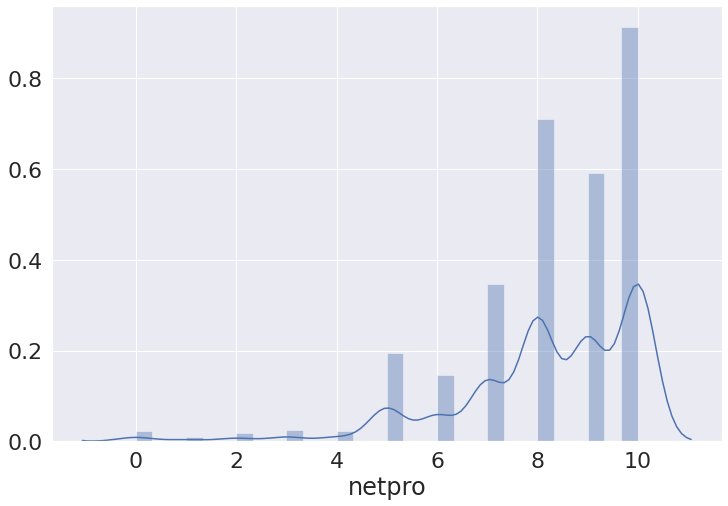

In [0]:
# Netpro is the net promoter score
# Most people are promoters
sns.distplot(model_fields['netpro'])


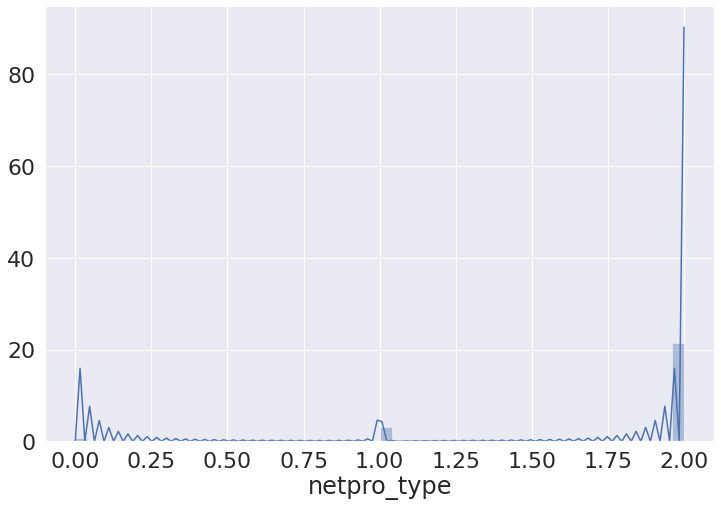

In [0]:
# compare to netpro_type
# netpro_type uses three states (promoter, neutral, detractor), but since we have so few
# non-promoters it doesn't help the model to add this small third set
sns.distplot(model_fields['netpro_type'])

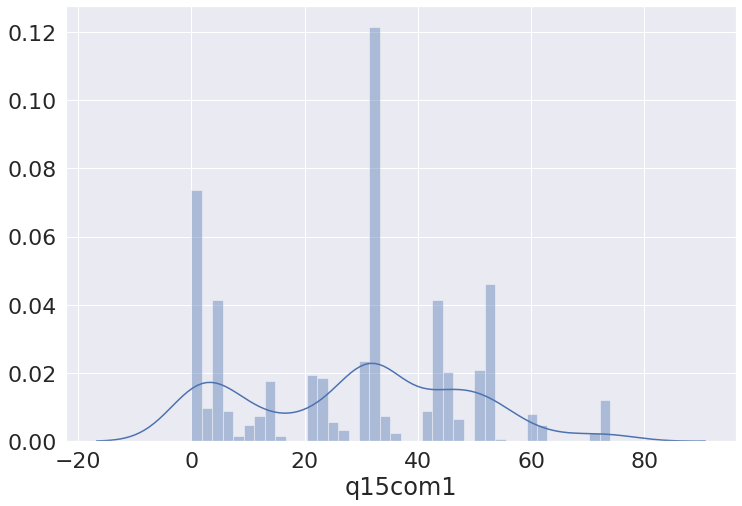

In [0]:
# Common complaints include "signs are confusing", "staff not helpful", "security took too long", 
# "airline rules on checked bags", "poor communication on gate change or delay"
sns.distplot(model_fields['q15com1'], bins=40)

In [0]:
# For net promoter score, if the score is 7 or above, it's good for us. 
# 0-5 and 11 and Nans are bad. 
# reference: https://stackoverflow.com/questions/20250771/remap-values-in-pandas-column-with-a-dict 

#netpro_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 11:0, np.nan:0, 6:0, \
#               7:1, 8:1, 9:1, 10:1}
#model_fields['promoter'] = model_fields['netpro'].map(netpro_dict)
#model_fields.Netpro_good

In [0]:
# Combine the "used Oakland" and "used San Jose" columns

# refernce: https://stackoverflow.com/questions/48369929/creating-a-new-column-based-on-the-values-of-other-columns
# df.loc[((df['Value_1'] > 1000) |(df['Value_2'] > 15000)), 'High_Value_Ind'] = 'Y'
# df['High_Value_Ind'] = df['High_Value_Ind'].fillna('N')

model_fields.loc[((model_fields['q24oak'] == 1) | (model_fields['q24sjc'] == 1)), 'oaksjc'] = 1
model_fields['oaksjc'] = model_fields['oaksjc'].fillna(0)
#model_fields['Oaksjc']

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

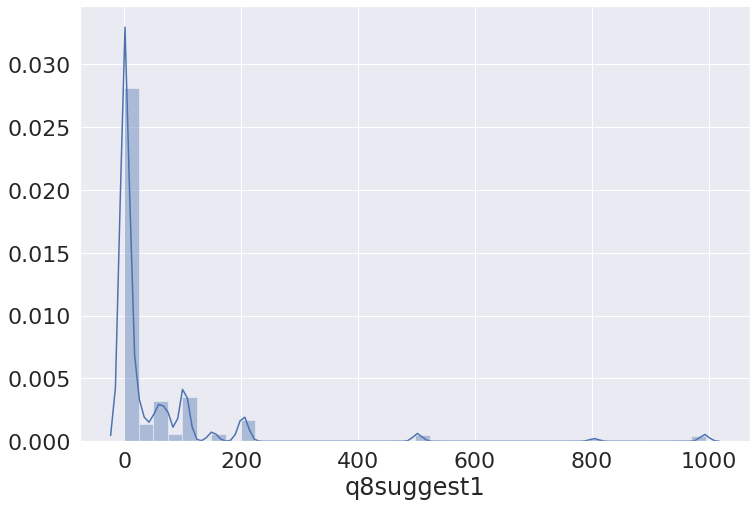

In [0]:
sns.distplot(model_fields['q8suggest1'], bins=40)

In [0]:
# This ends up not being useful, but because there were so many possible details in this field,
# it was worth trying

# There are many options for giving suggestions on how the airport can improve
# At this point in the model, I'm grouping them
# 0 = blanks and 0
# 1 = general positive
# 2 = amenities
# 3 = gates
# 4 = signage
# 5 = getting to the airport
# 6 = restaurants
# 7 = shops
# 8 = security/tsa
# 9 = airlines
# 10 = OAK/SJC is better
# 11 = other airports
# 102 = general neutral/don't know
# 103 = delays
# 104 = crowded
# 105 = construction
# 106 = staff positive
# 107 = staff negative
# 108 = accessible
# 109 = general negative
# 110 = expensive
# 111 = unsafe


improve_dict = {0:0, np.nan:0,\
                1:1, 
                2:102, 3:102, 4:102, 45:102,\
                5:103,\
                6:104, \
                7:105, \
                8:106, 9:107,\
                10:108, \
                41:111, \
                42:109, \
                44:110, \
                11:2, 12:2, 13:2, 14:2, 15:2, 16:2, 17:2, 18:2, 19:2, 20:2, 21:2, 23:2, 24:2, 25:2, 26:2, 27:2,\
                31:3, 32:3, 33:3, 34:3, 35:3, 36:3,\
                51:4, 52:4, 53:4, 54:4, 55:4, 56:4, 57:5, 58:5, 59:5, 60:5, 61:5, 62:5, 63:5, 64:5, 65:5, 66:5, 67:5,\
                71:5, 72:5, 73:5, 74:5, 75:5, 76:5, 77:5, 78:5,\
                101:6, 102:6, 103:6, 104:6, 105:6, 106:6, 107:6, 108:6, 109:6, 110:6,\
                151:7, 152:7, 153:7, 154:7, 155:7,\
                201:8, 202:8, 203:8, 204:8, 205:8, 206:8, 207:8, 208:8, 209:8, 210:8, 211:8, 212:8,\
                501:9, 502:9, 503:9, 504:9, 505:9, 510:9,\
                801:10,\
                802:11, 803:11, 804:11, 805:11, 806:11, 43:11,\
                991:1, 992:1, 993:1, 994:1, 995:1, 996:1, 999:1}

model_fields['improve'] = model_fields['q8suggest1'].map(improve_dict)
model_fields['improve'].fillna(0, inplace=True)
# model_fields['Improve']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


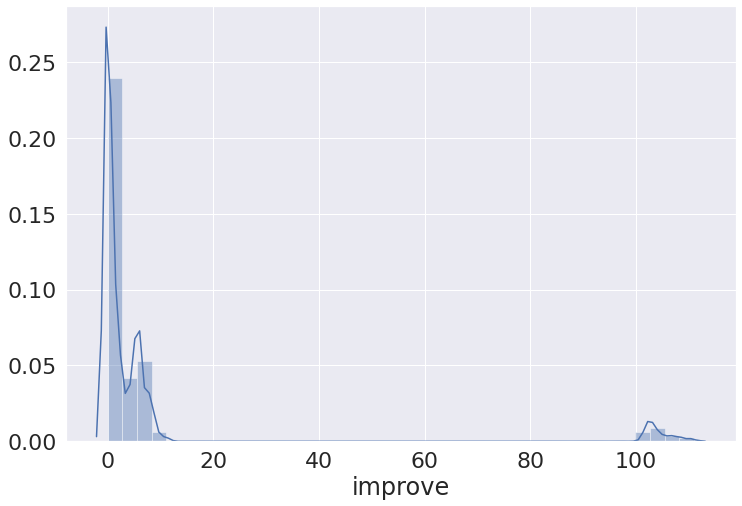

In [0]:
# "improve" is the list of ways the airport can improve. That big spike is security/tsa
sns.distplot(model_fields['improve'], bins = 40)

In [0]:
# Use one-hot encoding to split the Improve field into categories
# 0 = blanks and 0
# 1 = general positive
# 2 = amenities
# 3 = gates
# 4 = signage
# 5 = getting to the airport
# 6 = restaurants
# 7 = shops
# 8 = security/tsa
# 9 = airlines
# 10 = OAK/SJC is better
# 11 = other airports
# 102 = general neutral/don't know
# 103 = delays
# 104 = crowded
# 105 = construction
# 106 = staff positive
# 107 = staff negative
# 108 = accessible
# 109 = general negative
# 110 = expensive
# 111 = unsafe

# reference: https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/
# sample: y = pd.get_dummies(df.Countries, prefix='Country')

yimprove = pd.get_dummies(model_fields['improve'], prefix='imp')
yimprove = yimprove.rename(columns={'imp_0.0': 'imp_nothing',\
                                    'imp_1.0': 'imp_positive',\
                                    'imp_2.0': 'imp_amenities',\
                                    'imp_3.0': 'imp_gates',\
                                    'imp_4.0': 'imp_signup',\
                                    'imp_5.0': 'imp_gettingto',\
                                    'imp_6.0': 'imp_restaurants',\
                                    'imp_7.0': 'imp_shops',\
                                    'imp_8.0': 'imp_security',\
                                    'imp_9.0': 'imp_airlines',\
                                    'imp_10.0': 'imp_oaksjc',\
                                    'imp_11.0': 'imp_airports',\
                                    'imp_102.0': 'imp_neutral',\
                                    'imp_103.0': 'imp_delays',\
                                    'imp_104.0': 'imp_crowded',\
                                    'imp_105.0': 'imp_construction',\
                                    'imp_106.0': 'imp_staffpos',\
                                    'imp_107.0': 'imp_staffneg',\
                                    'imp_108.0': 'imp_accessible',\
                                    'imp_109.0': 'imp_neutral',\
                                    'imp_110.0': 'imp_expensive',\
                                    'imp_111.0': 'imp_unsafe'
                                    })
yimprove.head()

,imp_nothing,imp_positive,imp_amenities,imp_gates,imp_signup,imp_gettingto,imp_restaurants,imp_shops,imp_security,imp_airlines,imp_oaksjc,imp_airports,imp_neutral,imp_delays,imp_crowded,imp_construction,imp_staffpos,imp_staffneg,imp_accessible,imp_neutral,imp_expensive,imp_unsafe
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:

# only uncomment the next line and run it once per session or else you'll get extra columns
model_fields = pd.concat([model_fields, yimprove], axis=1, sort=False)
model_fields.head(10)

,respnum,day,barea,peak,destgeo,howlong,q2purp1,q3getto1,q3park,q4bags,q4store,q4food,q4wifi,q5timesflown,q5firsttime,q6longuse,q7art,q7food,q7store,q7sign,q7walkway,q7screens,q7infodown,q7infoup,q7wifi,q7roads,q7park,q7airtrain,q7ltparking,q7rental,q7all,q8suggest1,q8suggest2,q8suggest3,q8suggest4,q9boarding,q9airtrain,q9rental,q9food,q9restroom,q9all,q9com1,q9com2,q9com3,q10safe,q10com1,q10com2,q10com3,q11tsapre,q12precheckrate,q12com1,q12com2,q12com3,q13getrate,q14find,q14passthru,q15problem,q15com1,q15com2,q15com3,netpro,promoter,netpro_type,q17live,q20age,q21gender,q22income,q23fly,q24sjc,q24oak,lang,weight,oaksjc,improve,imp_nothing,imp_positive,imp_amenities,imp_gates,imp_signup,imp_gettingto,imp_restaurants,imp_shops,imp_security,imp_airlines,imp_oaksjc,imp_airports,imp_neutral,imp_delays,imp_crowded,imp_construction,imp_staffpos,imp_staffneg,imp_accessible,imp_neutral,imp_expensive,imp_unsafe
0,1,7,G,3,4,210.0,2,7,NaN,1,2,2,1,1,1,1,6,6,6,3,3,3,6,6,4,6,6,6,6,6,4.0,0,NaN,NaN,NaN,5,6,6,6,4,4,0,NaN,NaN,4,3,NaN,NaN,2,NaN,NaN,NaN,NaN,4,4,4,2,NaN,NaN,NaN,6,0,1,3,5,2,3,1,2,2,1,0.284718,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,7,F,3,4,235.0,4,6,NaN,2,1,1,2,3,1,4,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3.0,0,NaN,NaN,NaN,3,3,3,3,3,3,0,NaN,NaN,3,11,NaN,NaN,2,NaN,NaN,NaN,NaN,3,4,5,2,NaN,NaN,NaN,7,1,2,1,3,1,1,2,2,2,1,0.944082,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,7,G,3,4,60.0,2,3,NaN,0,0,1,1,1,1,4,5,5,4,4,4,4,6,6,5,6,6,6,6,6,4.0,14,NaN,NaN,NaN,5,6,6,5,5,5,0,NaN,NaN,4,6,NaN,NaN,4,NaN,NaN,NaN,NaN,0,5,6,2,NaN,NaN,NaN,5,0,1,3,6,2,3,2,2,1,1,0.284718,1.0,2.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,7,F,3,4,175.0,2,9,NaN,1,1,1,1,0,0,0,5,5,5,5,5,5,3,3,3,4,4,4,4,4,4.0,0,NaN,NaN,NaN,4,4,4,4,4,4,0,NaN,NaN,4,0,NaN,NaN,2,NaN,NaN,NaN,NaN,5,5,5,2,NaN,NaN,NaN,7,1,2,1,5,2,2,2,1,1,1,0.944082,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,7,G,3,4,150.0,2,5,NaN,1,1,1,2,1,1,2,6,3,3,4,4,4,4,4,2,4,6,6,6,6,4.0,0,NaN,NaN,NaN,5,6,6,5,5,5,0,NaN,NaN,5,0,NaN,NaN,2,NaN,NaN,NaN,NaN,5,5,5,2,NaN,NaN,NaN,9,1,2,3,4,2,4,1,2,2,1,0.284718,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,6,7,G,3,4,120.0,1,3,NaN,1,1,1,1,1,1,2,3,3,3,4,4,4,3,6,3,4,4,6,6,6,4.0,0,NaN,NaN,NaN,5,6,6,5,5,5,0,NaN,NaN,4,1,2.0,3.0,0,NaN,NaN,NaN,NaN,4,4,5,2,NaN,NaN,NaN,10,1,2,3,5,1,0,2,2,2,1,0.284718,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,7,7,F,3,4,205.0,2,12,NaN,1,2,2,2,0,0,0,4,4,3,3,3,4,4,4,4,3,0,4,4,4,4.0,32,NaN,NaN,NaN,4,4,4,4,4,4,0,NaN,NaN,4,15,NaN,NaN,1,5,1,NaN,NaN,3,3,3,2,NaN,NaN,NaN,8,1,2,1,4,1,4,2,2,2,1,0.944082,0.0,3.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,8,7,G,3,4,180.0,2,0,NaN,1,2,1,2,1,2,1,6,4,6,4,4,4,6,6,6,6,6,6,6,6,4.0,0,NaN,NaN,NaN,4,6,6,4,4,4,0,NaN,NaN,5,0,NaN,NaN,1,4,0,NaN,NaN,4,4,4,2,NaN,NaN,NaN,9,1,2,3,6,2,2,3,3,4,1,0.284718,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,9,7,F,3,4,205.0,4,3,NaN,1,1,1,1,2,1,1,5,3,4,5,5,5,5,5,5,6,6,6,6,6,4.0,8,NaN,NaN,NaN,5,5,5,5,5,5,0,NaN,NaN,5,1,NaN,NaN,3,NaN,NaN,NaN,NaN,5,5,5,2,NaN,NaN,NaN,9,1,2,3,2,1,1,2,2,2,2,0.944082,0.0,106.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9,10,7,G,3,4,180.0,2,7,NaN,1,1,1,1,1,1,3,6,4,4,5,5,5,6,6,4,6,6,6,6,6,5.0,1,8.0,NaN,NaN,5,6,6,4,3,5,0,NaN,NaN,5,0,NaN,NaN,1,5,0,NaN,NaN,5,5,5,2,NaN,NaN,NaN,10,1,2,3,4,2,0,1,2,2,1,0.284718,0.0,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


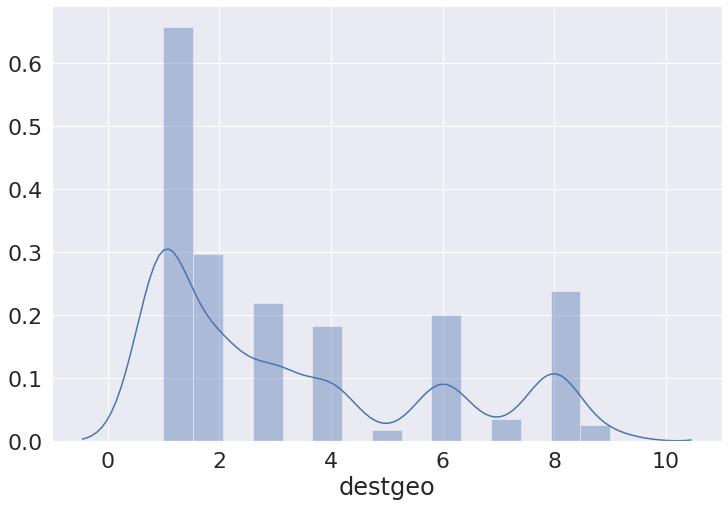

In [0]:
sns.distplot(model_fields['destgeo'])

In [0]:
intl_dict = {0:0, np.nan:0,\
             1:0, 2:0, 3:0, 10:0,\
             4:1, 5:1, 6:1, 7:1, 8:1, 9:1}

model_fields['destintl'] = model_fields['destgeo'].map(intl_dict)
model_fields['destintl'].fillna(0, inplace=True)
#model_fields['Destintl']

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [0]:
avg_model = model_fields.mean()
median_model = model_fields.median()
values = pd.concat([median_model, avg_model], axis=1).reset_index()
values = values.transpose()
values.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92
index,respnum,day,peak,destgeo,howlong,q2purp1,q3getto1,q4bags,q4store,q4food,q4wifi,q5timesflown,q5firsttime,q6longuse,q7art,q7food,q7store,q7sign,q7walkway,q7screens,q7infodown,q7infoup,q7wifi,q7roads,q7park,q7airtrain,q7ltparking,q7rental,q7all,q8suggest1,q8suggest2,q8suggest3,q8suggest4,q9boarding,q9airtrain,q9rental,q9food,q9restroom,q9all,q9com1,q9com2,q9com3,q10safe,q10com1,q10com2,q10com3,q11tsapre,q12com2,q12com3,q13getrate,q14find,q14passthru,q15problem,q15com1,q15com2,q15com3,netpro,promoter,netpro_type,q17live,q20age,q21gender,q22income,q23fly,q24sjc,q24oak,lang,weight,oaksjc,improve,imp_nothing,imp_positive,imp_amenities,imp_gates,imp_signup,imp_gettingto,imp_restaurants,imp_shops,imp_security,imp_airlines,imp_oaksjc,imp_airports,imp_neutral,imp_delays,imp_crowded,imp_construction,imp_staffpos,imp_staffneg,imp_accessible,imp_neutral,imp_expensive,imp_unsafe,destintl
0,1645.5,4,2,2,140,2,4,1,2,1,1,2,1,3,4,4,4,4,4,4,5,5,5,4,6,5,6,6,4,1,71.5,63.5,75,5,5,6,4,4,4,0,5,2,5,0,3,7,2,4,12,4,5,5,2,32,13,42,9,1,2,3,4,2,2,2,2,2,1,1.03803,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1633.02,3.92142,2.12787,3.37083,161.539,2.22257,4.39937,1.33858,1.39826,1.34785,1.32746,2.22368,1.20589,2.5821,4.18495,3.81338,3.81987,4,4.13491,4.06153,4.54522,4.50519,4.31097,4.37824,4.76334,4.72405,5.03021,4.86471,3.99092,48.2969,133.108,147.371,143.261,4.30189,4.77669,4.90178,4.31894,4.05486,4.14548,0.236471,6.44444,2,4.31338,2.62046,5.57627,7,1.71497,7.88732,12,3.81709,4.33302,4.15437,1.82635,28.8368,23.7922,36.2857,8.20682,0.853781,1.82876,2.20793,4.26464,1.55708,2.15697,1.93254,1.79299,1.76427,1.10156,0.999884,0.361379,7.81375,0.510007,0.0670867,0.0869162,0.0218681,0.0218681,0.0724611,0.0883988,0.0150111,0.0428095,0.0116753,0.000370645,0.00481838,0.016679,0.0135285,0.00685693,0.00370645,0.00352113,0.00389177,0.00315048,0.00203855,0.0016679,0.0016679,0.373981


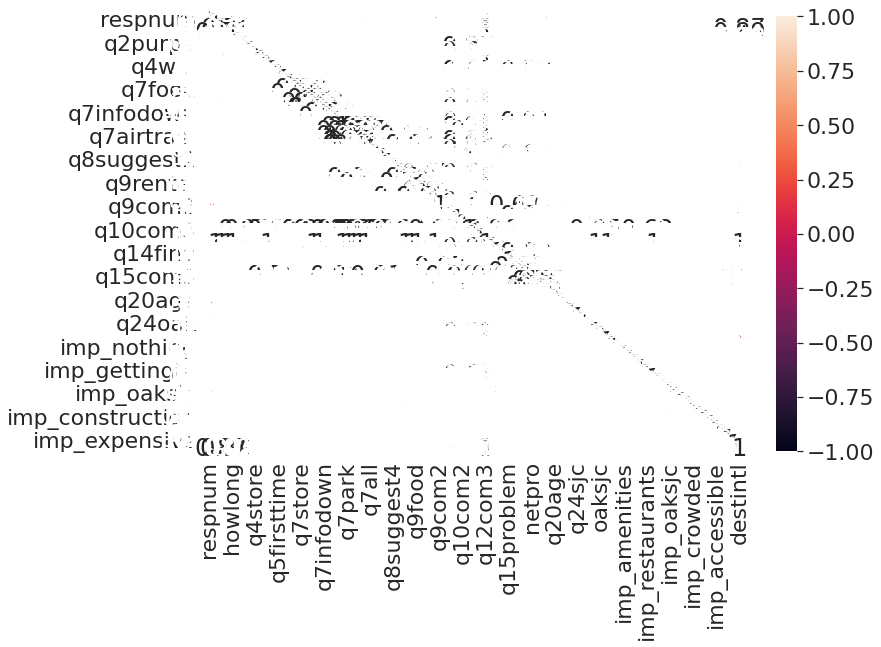

In [0]:
# I've commented out most of the correlation plots to save time when I re-run the code
# I used them to find fields that had some correlation with the goal variable
# because there are a lot of fields, I made a lot of plots
# this can be done in other ways (like chisq), but I like looking at the data

model_corr1 = model_fields.corr()

sns.heatmap(model_corr1, annot=True)

In [0]:
model2_fields = model_fields.loc[:, ['q2purp1', 'q3getto1', 'q4bags', 'q4store', 'q4food', 'q4wifi', 'improve']]

In [0]:
#model_corr2 = model2_fields.corr()

#sns.heatmap(model_corr2, annot=True)

# drop Q2purp, Q3getto1

In [0]:
model3_fields = model_fields.loc[:, ['q7art', 'q7food', 'q7store', 'q7sign', 'q7walkway',  'q7screens', \
                                     'q7infodown', 'q7infoup', 'q7wifi',  'q7roads',\
                                     'q7park',   'q7airtrain',   'q7ltparking',  'q7rental',   \
                                     'q7all', 'improve']]
#model_corr3 = model3_fields.corr()

#sns.heatmap(model_corr3, annot=True)               

# keep 'Q7food', 'Q7store', 'Q7sign', 'Q7walkway',  'Q7screens',

In [0]:
model4_fields = model_fields.loc[:, ['q8suggest1', 'q9boarding', 'q9airtrain', 'q9rental', 'q9food', 'q9restroom', 'q9all', 'q9com1', 'improve']]
#model_corr4 = model4_fields.corr()

#sns.heatmap(model_corr4, annot=True) 

# drop Q8-1, Q9-1

In [0]:
model5_fields = model_fields.loc[:, ['q10safe', 'q10com1', 'q11tsapre', 'q13getrate',  'q14find', 'q14passthru']]
#model_corr5 = model5_fields.corr()

#sns.heatmap(model_corr5, annot=True) 

#keep q10safe, q14find, q14passthru

In [0]:
model6_fields = model_fields.loc[:, ['q15problem', 'promoter',  'q17live', \
                                     'q20age', 'q21gender', 'q22income', 'q23fly', 'q24sjc', \
                                     'q24oak', 'lang']]
#model_corr6 = model6_fields.corr()

#sns.heatmap(model_corr6, annot=True) 

# keep q17live, q23fly, q23sjc, q24oak

In [0]:
model7_fields = model_fields.loc[:, ['q5timesflown', 'q5firsttime', 'q6longuse', 'q4bags', 'q4store', 'q4food', 'q4wifi', 'q7food', \
                                     'q7store', 'q7sign', 'q7walkway',  'q7screens', 'q9boarding', 'q9airtrain', 'q9rental', 'q9food', \
                                     'promoter']]
#model_corr7 = model7_fields.corr()

#sns.heatmap(model_corr7, annot=True) 


In [0]:
model8_fields = model_fields.loc[:, ['q9restroom', 'q9all', 'q10safe', 'q14find', 'q14passthru', 'q17live', 'q20age', 'q21gender', \
                                     'q22income', 'q23fly', 'q24sjc', 'q24oak', 'promoter']]
#model_corr8 = model8_fields.corr()

#sns.heatmap(model_corr8, annot=True) 

In [0]:
model9_fields = model_fields.loc[:, ['destgeo', 'q5timesflown', 'q4bags', 'q4wifi', 'q7food', \
                                     'q7store', 'q7sign', 'q9all', 'q10safe', \
                                     'q14find', 'q14passthru', 'q17live',\
                                     'q23fly', 'oaksjc',\
                                     'promoter']]

#model_corr9 = model9_fields.corr()

#sns.heatmap(model_corr9, annot=True) 

In [0]:
# Imp_nothing	Imp_positive	Imp_amenities	Imp_gates	Imp_signup	
# Imp_gettingto	Imp_restaurants	Imp_shops	Imp_security	Imp_airlines	
# Imp_oaksjc	Imp_airports	Imp_neutral	Imp_delays	Imp_crowded	
# Imp_construction	Imp_staffpos	Imp_staffneg	Imp_accessible	
# Imp_neutral	Imp_expensive	Imp_unsafe	

model10a_fields = model_fields.loc[:, ['promoter',	'imp_nothing', 'imp_amenities', 'imp_gates',\
                                     'imp_signup', 'imp_gettingto', 'imp_restaurants', 'imp_shops', 'imp_security',\
                                    'imp_airlines', 'imp_oaksjc', 'imp_airports', 'imp_positive']]
#model_corr10a = model10a_fields.corr()
#plt.figure(figsize=(16,5))
#sns.heatmap(model_corr10a, annot=True) 

In [0]:
model10b_fields = model_fields.loc[:, ['promoter', 'imp_positive',\
                                    'imp_neutral', 'imp_delays', 'imp_crowded',\
                                    'imp_construction',	'imp_staffpos',	'imp_staffneg',\
                                    'imp_accessible', 'imp_neutral', 'imp_expensive',	'imp_unsafe']]
#model_corr10b = model10b_fields.corr()
#plt.figure(figsize=(16,5))
#sns.heatmap(model_corr10b, annot=True) 

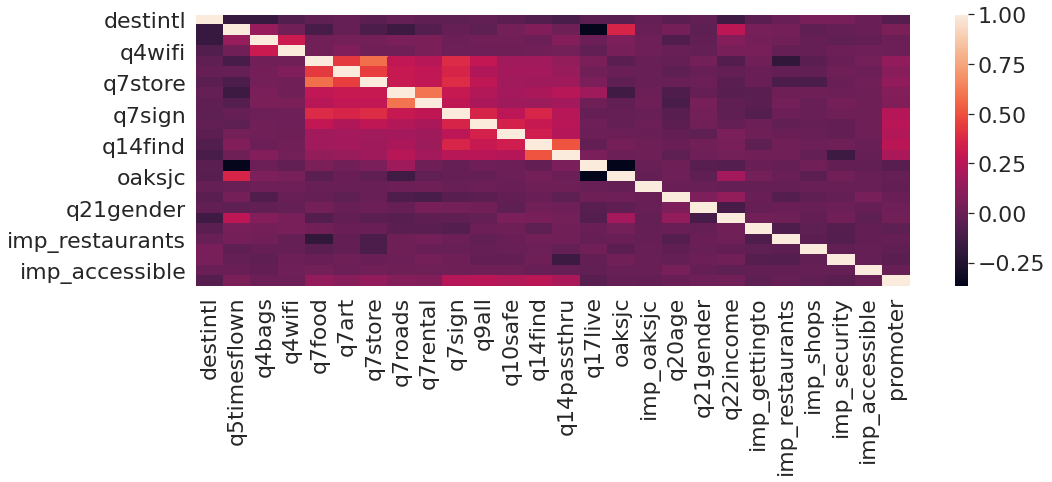

In [0]:

model11_fields = model_fields.loc[:, ['destintl', 'q5timesflown', 'q4bags',\
                                      'q4wifi', 'q7food', 'q7art',\
                                      'q7store', 'q7roads', 'q7rental', 'q7sign', 'q9all', 'q10safe', \
                                      'q14find', 'q14passthru', 'q17live',\
                                      'oaksjc', 'imp_oaksjc',\
                                      'q20age', 'q21gender', 'q22income',\
                                      'imp_gettingto', 'imp_restaurants', 'imp_shops', 'imp_security',\
                                      'imp_accessible', 'promoter']]

model_corr11 = model11_fields.corr()
plt.figure(figsize=(16,5))
sns.heatmap(model_corr11) 

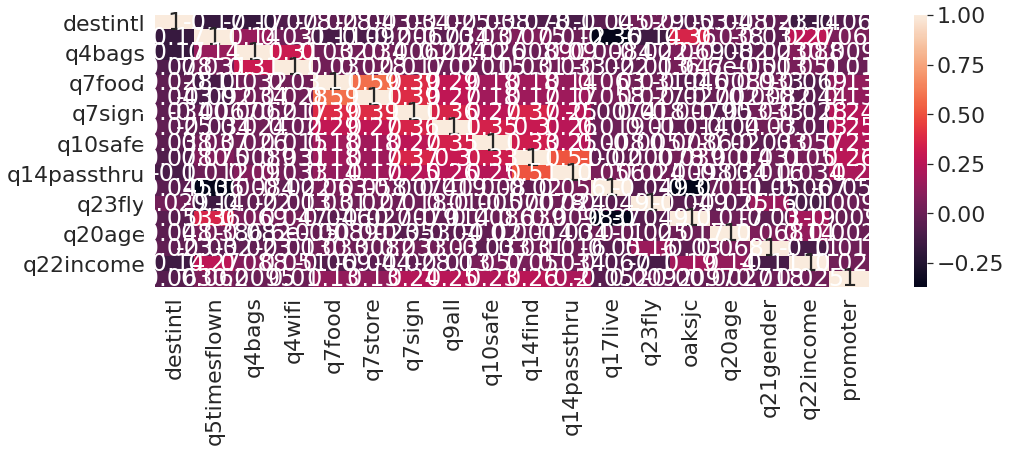

In [0]:
model12_fields = model_fields.loc[:, ['destintl', 'q5timesflown', 'q4bags', 'q4wifi', 'q7food',\
                                     'q7store', 'q7sign', 'q9all', 'q10safe', \
                                     'q14find', 'q14passthru', 'q17live',\
                                     'q23fly', 'oaksjc',\
                                      'q20age', 'q21gender', 'q22income',\
                                     'promoter']]

model_corr12 = model12_fields.corr()
plt.figure(figsize=(16,5))
sns.heatmap(model_corr12, annot=True) 

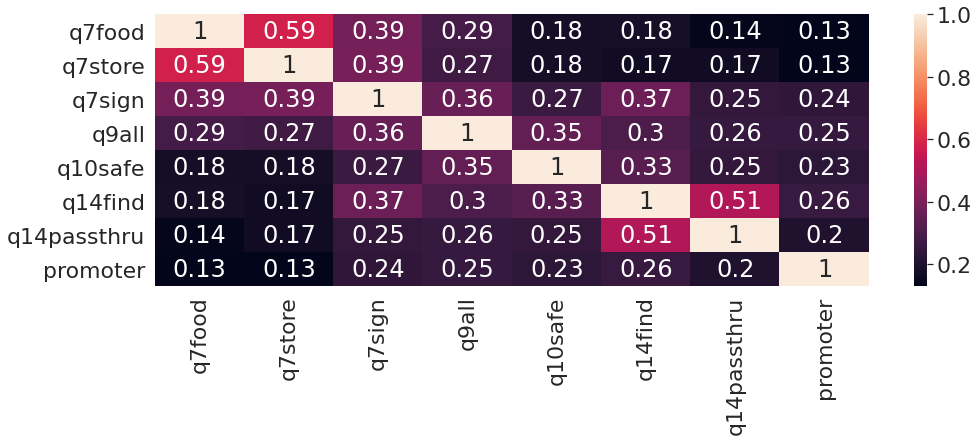

In [0]:
model13_fields = model_fields.loc[:, ['q7food',\
                                     'q7store', 'q7sign', 'q9all', 'q10safe', \
                                     'q14find', 'q14passthru',\
                                     'promoter']]

model_corr13 = model13_fields.corr()
plt.figure(figsize=(16,5))
sns.heatmap(model_corr13, annot=True) 

# Models

* I created several functions for the models and their tuning parameters
* Models include:
  * logistic regression
  * k-nearest neighbors
  * random forest
  * naive bayes (Gaussian and Bernoulli)
  * decision trees
  * mlp
  * svm

Reference: https://scikit-learn.org/stable/





In [0]:
# check that the distribution between training and test is fair across the two outcomes

def check_distribution (X_train, X_test, y_train, y_test):
  n_classes = 2

  training_counts = [None] * n_classes 
  testing_counts = [None] * n_classes
  for i in range(n_classes):
    training_counts[i] = len(y_train[y_train == i])/len(y_train)
    testing_counts[i] = len(y_test[y_test == i])/len(y_test)

  # the histogram of the data
  train_bar = plt.bar(np.arange(n_classes)-0.2, training_counts, align='center', color = 'r', alpha=0.75, width = 0.41, label='Training')
  test_bar = plt.bar(np.arange(n_classes)+0.2, testing_counts, align='center', color = 'b', alpha=0.75, width = 0.41, label = 'Testing')

  plt.xlabel('Labels')
  plt.xticks((0,1))
  plt.ylabel('Count (%)')
  plt.title('Label distribution in the training and test set')
  plt.legend(bbox_to_anchor=(1.05, 1), handles=[train_bar, test_bar], loc=2)
  plt.grid(True)
  plt.show()




In [0]:
def run_logress (X_train, X_test, y_train, y_test, iterations):


  # MODEL BUILD - LogisticRegression
  #from sklearn.linear_model import LogisticRegression
  clf = LogisticRegression(max_iter=iterations)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  dec_fn = clf.decision_function(X_test)
  accuracy = clf.score(X_test, y_test)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  rocauc = roc_auc_score(y_test, dec_fn )
  conf_mat = confusion_matrix(y_test, y_pred)

  return accuracy, precision, recall, f1, rocauc, conf_mat


def run_logress_multi (X_train, X_test, y_train, y_test, iterations):

  # MODEL BUILD - LogisticRegression
  #from sklearn.linear_model import LogisticRegression
  clf = LogisticRegression(max_iter=iterations, multi_class="multinomial")
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  dec_fn = clf.decision_function(X_test)
  accuracy = clf.score(X_test, y_test)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  rocauc = roc_auc_score(y_test, dec_fn )
  conf_mat = confusion_matrix(y_test, y_pred)

  return accuracy, precision, recall, f1, rocauc, conf_mat

In [0]:
#X1a_score, X1a_precision, X1a_recall, X1a_f1, X1a_rocauc = run_logress(X1_train, X1_test, y1_train, y1_test, 1000)
#print('X1a logistic regression scores:', X1a_score, X1a_precision, X1a_recall, X1a_f1, X1a_rocauc)
#X1a_results = pd.DataFrame(['Logistic regression', X1a_score, X1a_precision, X1a_recall, X1a_f1, X1a_rocauc])
#X1a_results

In [0]:

def run_knear (X_train, X_test, y_train, y_test, k):

  # MODEL BUILD - K-Nearest Neighbors

  #from sklearn.neighbors import KNeighborsClassifier
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh.fit(X_train, y_train)
  y_pred = neigh.predict(X_test)
  y_proba = neigh.predict_proba(X_test)[:,1]
  accuracy = neigh.score(X_test, y_test)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  rocauc = roc_auc_score(y_test, y_proba)
  conf_mat = confusion_matrix(y_test, y_pred)
  
  return accuracy, precision, recall, f1, rocauc, conf_mat

In [0]:
#X1c_score, X1c_precision, X1c_recall, X1c_f1, X1c_rocauc = run_knear(X1_train, X1_test, y1_train, y1_test, 3)
#X1c_results = pd.DataFrame(['X1c: KNN, 3', X1c_score, X1c_precision, X1c_recall, X1c_f1, X1c_rocauc])
#print(X1c_results)

In [0]:
def run_forest (X_train, X_test, y_train, y_test, n):

  # MODEL BUILD - RANDOM FORESTS
  #from sklearn.ensemble import RandomForestClassifier 

  forest = RandomForestClassifier(n_estimators = n)
  forest.fit(X_train, y_train)
  y_pred = forest.predict(X_test)
  y_proba = forest.predict_proba(X_test)[:,1]
  accuracy = forest.score(X_test, y_test)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  rocauc = roc_auc_score(y_test, y_proba)
  importances = forest.feature_importances_
  conf_mat = confusion_matrix(y_test, y_pred)
  
  return accuracy, precision, recall, f1, rocauc, importances, conf_mat 


In [0]:
#X1f_score, X1f_precision, X1f_recall, X1f_f1, X1f_rocauc, X1f_imp, X1f_confuse = run_forest(X1_train, X1_test, y1_train, y1_test, 100)
#X1f_results = pd.DataFrame(['X1f: Random Forest, 100', X1f_score, X1f_precision, X1f_recall, X1f_f1, X1f_rocauc])
#print(X1f_results)
#print(X1f_confuse)

In [0]:
def run_mlp (X_train, X_test, y_train, y_test, iterations):

#>>> clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
#>>> clf.predict_proba(X_test[:1])

  clf = MLPClassifier(random_state=42, max_iter=iterations).fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  y_proba = clf.predict_proba(X_test)[:,1]
  accuracy = clf.score(X_test, y_test)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  rocauc = roc_auc_score(y_test, y_proba)
  conf_mat = confusion_matrix(y_test, y_pred)
  
  return accuracy, precision, recall, f1, rocauc, conf_mat

In [0]:
## this is the function for what will end up being the best model

def run_naive (X_train, X_test, y_train, y_test):

  #from sklearn.naive_bayes import GaussianNB
  bay = sklearn.naive_bayes.GaussianNB()
  bay.fit(X_train, y_train)
  y_pred = bay.predict(X_test)
  y_proba = bay.predict_proba(X_test)[:,1]
  accuracy = bay.score(X_test, y_test)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  rocauc = roc_auc_score(y_test, y_proba)
  conf_mat = confusion_matrix(y_test, y_pred)
  
  return accuracy, precision, recall, f1, rocauc, conf_mat


In [0]:
def tune_naive (X_train, X_test, y_train, y_test, smooth):
  bay = sklearn.naive_bayes.GaussianNB(var_smoothing= smooth)
  bay.fit(X_train, y_train)
  y_pred = bay.predict(X_test)
  y_proba = bay.predict_proba(X_test)[:,1]
  #accuracy = bay.score(X_test, y_test)
  #precision = precision_score(y_test, y_pred)
  #recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  rocauc = roc_auc_score(y_test, y_proba)
  conf_mat = confusion_matrix(y_test, y_pred)
  
  return smooth, f1, rocauc, conf_mat

In [0]:
def tune_bern (X_train, X_test, y_train, y_test):
  bay = sklearn.naive_bayes.BernoulliNB()
  bay.fit(X_train, y_train)
  y_pred = bay.predict(X_test)
  y_proba = bay.predict_proba(X_test)[:,1]
  #accuracy = bay.score(X_test, y_test)
  #precision = precision_score(y_test, y_pred)
  #recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  rocauc = roc_auc_score(y_test, y_proba)
  conf_mat = confusion_matrix(y_test, y_pred)
  
  return f1, rocauc, conf_mat

In [0]:
#X1g_score, X1g_precision, X1g_recall, X1g_f1, X1g_rocauc = run_naive(X1_train, X1_test, y1_train, y1_test)
#X1g_results = pd.DataFrame(['X1g NB:', X1g_score, X1g_precision, X1g_recall, X1g_f1, X1g_rocauc])
#print(X1g_results)

In [0]:
def run_tree (X_train, X_test, y_train, y_test):

  # from sklearn.tree import DecisionTreeClassifier
  tree = sklearn.tree.DecisionTreeClassifier()
  tree.fit(X_train, y_train)
  y_pred = tree.predict(X_test)
  y_proba = tree.predict_proba(X_test)[:,1]
  accuracy = tree.score(X_test, y_test)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  rocauc = roc_auc_score(y_test, y_proba)
  conf_mat = confusion_matrix(y_test, y_pred)
  
  return accuracy, precision, recall, f1, rocauc, conf_mat



In [0]:
#X1h_score, X1h_precision, X1h_recall, X1h_f1, X1h_rocauc = run_tree(X1_train, X1_test, y1_train, y1_test)
#print('X1h: DecTree', X1h_score, X1h_precision, X1h_recall, X1h_f1, X1h_rocauc)
#X1h_results = pd.DataFrame(['X1h: DecTree', X1h_score, X1h_precision, X1h_recall, X1h_f1, X1h_rocauc])
#print(X1h_results)

In [0]:
def run_svc (X_train, X_test, y_train, y_test, maxiter):

  #sklearn.svm.LinearSVC (setting multi_class=”crammer_singer”)
  vector = make_pipeline(StandardScaler(),
                         LinearSVC(random_state=42, multi_class='ovr', max_iter=maxiter))
  vector.fit(X_train, y_train)
  y_pred = vector.predict(X_test)
  dec_fn = vector.decision_function(X_test)
  accuracy = vector.score(X_test, y_test)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  rocauc = roc_auc_score(y_test, dec_fn )
  conf_mat = confusion_matrix(y_test, y_pred)

  return accuracy, precision, recall, f1, rocauc, conf_mat


In [0]:
# Linear SVC
#X1i_score, X1i_precision, X1i_recall, X1i_f1, X1i_rocauc = run_svc(X1_train, X1_test, y1_train, y1_test, 3000)
#print('X1i: SVC', X1i_score, X1i_precision, X1i_recall, X1i_f1, X1i_rocauc)
#X1i_results = pd.DataFrame(['X1i: SVC', X1i_score, X1i_precision, X1i_recall, X1i_f1, X1i_rocauc])
#print(X1i_results)

## Model set 1

In [0]:
# create training and test sets with 33/66 split

X1 = np.asarray(model_fields[['destintl', 'q5timesflown', 'q4bags', 'q4wifi', 'q7food',\
                             'q7store','q7sign', 'q9all', 'q10safe', 'q14find', 'q14passthru',\
                             'q17live','q23fly', 'oaksjc', 'imp_oaksjc', 'q20age', 'q21gender',\
                             'q22income', 'imp_gettingto', 'imp_restaurants', 'imp_shops',
                             'imp_security','imp_accessible']])
y = np.asarray(model_fields['promoter'])

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.33, random_state=42)



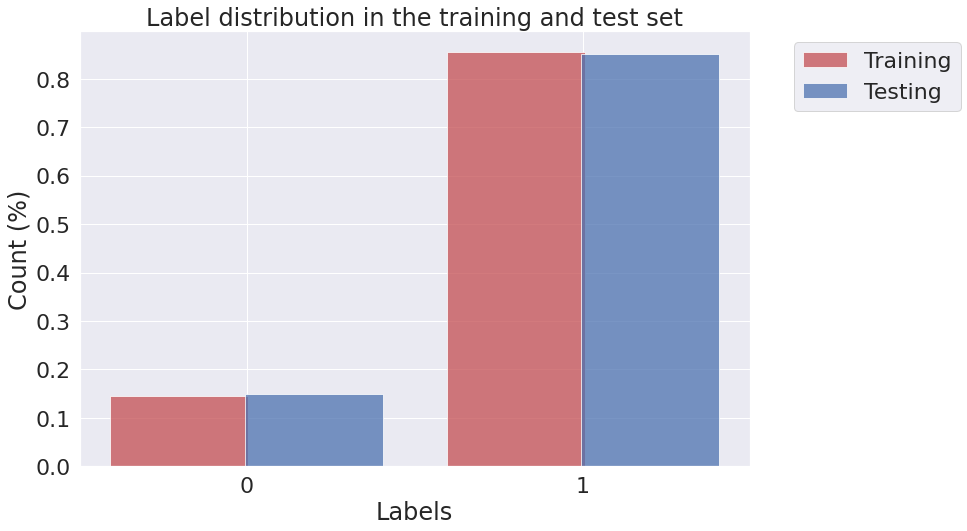

In [0]:
check_distribution(X1_train, X1_test, y1_train, y1_test)

Fields in round 1:
['destintl', 'q5timesflown', 'q4bags', 'q4wifi', 'q7food', 'q7art', 'q7store', 'q7roads', 'q7rental', 'q7sign', 'q9all', 'q10safe', 'q14find', 'q14passthru', 'q17live', 'oaksjc', 'imp_oaksjc', 'q20age', 'q21gender', 'q22income', 'imp_gettingto', 'imp_restaurants', 'imp_shops', 'imp_security', 'imp_accessible', 'promoter']
AxesSubplot(0.125,0.125;0.62x0.755)
X1 feature importance:


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,0,Importance
9,q7sign,0.087362
10,q9all,0.080014
7,q7roads,0.077878
15,oaksjc,0.076844
8,q7rental,0.076321
6,q7store,0.073296
4,q7food,0.066500
17,q20age,0.060483
5,q7art,0.060342
1,q5timesflown,0.055196


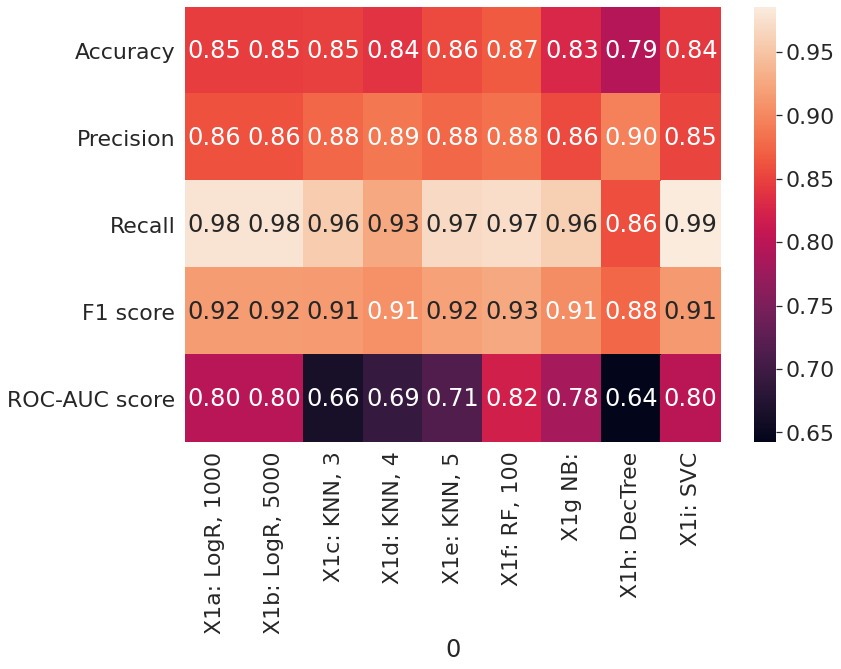

In [0]:

featimp1 = pd.DataFrame(list(model11_fields))
featimp1 = featimp1.loc[0:22, :]

print('Fields in round 1:')
print(list(model11_fields))

# Logistic regression, 0/1
X1a_score, X1a_precision, X1a_recall, X1a_f1, X1a_rocauc, X1a_confuse = run_logress(X1_train, X1_test, y1_train, y1_test, 1000)
X1a_results = pd.DataFrame(['X1a: LogR, 1000', X1a_score, X1a_precision, X1a_recall, X1a_f1, X1a_rocauc])
#print(X1a_results)

# Logistic regression, 0/1
X1b_score, X1b_precision, X1b_recall, X1b_f1, X1b_rocauc, X1b_confuse = run_logress(X1_train, X1_test, y1_train, y1_test, 5000)
X1b_results = pd.DataFrame(['X1b: LogR, 5000', X1b_score, X1b_precision, X1b_recall, X1b_f1, X1b_rocauc])
#print(X1b_results)


# K nearest neighbors
X1c_score, X1c_precision, X1c_recall, X1c_f1, X1c_rocauc, X1c_confuse = run_knear(X1_train, X1_test, y1_train, y1_test, 3)
X1c_results = pd.DataFrame(['X1c: KNN, 3', X1c_score, X1c_precision, X1c_recall, X1c_f1, X1c_rocauc])
#print(X1c_results)

# K nearest neighbors
X1d_score, X1d_precision, X1d_recall, X1d_f1, X1d_rocauc, X1d_confuse = run_knear(X1_train, X1_test, y1_train, y1_test, 4)
X1d_results = pd.DataFrame(['X1d: KNN, 4', X1d_score, X1d_precision, X1d_recall, X1d_f1, X1d_rocauc])
#print(X1d_results)

# K nearest neighbors
X1e_score, X1e_precision, X1e_recall, X1e_f1, X1e_rocauc, X1e_confuse = run_knear(X1_train, X1_test, y1_train, y1_test, 5)
X1e_results = pd.DataFrame(['X1e: KNN, 5', X1e_score, X1e_precision, X1e_recall, X1e_f1, X1e_rocauc])
#print(X1e_results)

# Random Forest
X1f_score, X1f_precision, X1f_recall, X1f_f1, X1f_rocauc, X1f_imp, X1f_confuse = run_forest(X1_train, X1_test, y1_train, y1_test, 100)
X1f_results = pd.DataFrame(['X1f: RF, 100', X1f_score, X1f_precision, X1f_recall, X1f_f1, X1f_rocauc])
#print(X1f_results)

# Naive Bayes
X1g_score, X1g_precision, X1g_recall, X1g_f1, X1g_rocauc, X1g_confuse = run_naive(X1_train, X1_test, y1_train, y1_test)
X1g_results = pd.DataFrame(['X1g NB:', X1g_score, X1g_precision, X1g_recall, X1g_f1, X1g_rocauc])
#print(X1g_results)

# Decision Trees
X1h_score, X1h_precision, X1h_recall, X1h_f1, X1h_rocauc, X1h_confuse = run_tree(X1_train, X1_test, y1_train, y1_test)
X1h_results = pd.DataFrame(['X1h: DecTree', X1h_score, X1h_precision, X1h_recall, X1h_f1, X1h_rocauc])
#print(X1h_results)

# Linear SVC
X1i_score, X1i_precision, X1i_recall, X1i_f1, X1i_rocauc, X1i_confuse = run_svc(X1_train, X1_test, y1_train, y1_test, 3000)
#print('X1i: SVC', X1i_score, X1i_precision, X1i_recall, X1i_f1, X1i_rocauc)
X1i_results = pd.DataFrame(['X1i: SVC', X1i_score, X1i_precision, X1i_recall, X1i_f1, X1i_rocauc])
#print(X1i_results)

# https://medium.com/swlh/recall-precision-f1-roc-auc-and-everything-542aedf322b9
x1frames = [X1a_results, X1b_results, X1c_results, X1d_results, X1e_results, X1f_results, X1g_results, X1h_results, X1i_results]
Results_forX1 = pd.concat(x1frames, axis=1)
Results_forX1.columns = Results_forX1.iloc[0]
Results_forX1 = Results_forX1.drop(index=0)
Results_forX1 = Results_forX1.rename(index={1:'Accuracy', 2:'Precision', 3:'Recall', 4:'F1 score', 5:'ROC-AUC score'})
Results_forX1 = Results_forX1.astype(float)
#print(Results_forX1)
print(sns.heatmap(Results_forX1, annot=True, fmt=".2f"))


# Feature importance from Random Forest
featimp1['Importance'] = X1f_imp
featimp1 = featimp1.sort_values('Importance', ascending=False)
print('X1 feature importance:')
featimp1

In [0]:
print('Field set 1 winners:\n')
print('Logistic regression')
print(X1a_confuse, '\n')
print('Naive Bayes')
print(X1g_confuse, '\n')
print('Random Forest')
print(X1f_confuse, '\n')
print('Linear SVC')
print(X1i_confuse)

Field set 1 winners:

Logistic regression
[[  26  239]
 [  33 1483]] 

Naive Bayes
[[  22  243]
 [  62 1454]] 

Random Forest
[[  70  195]
 [  41 1475]] 

Linear SVC
[[   7  258]
 [  22 1494]]


## Model set 2


In [0]:
# create training and test sets with 33/66 split

X2 = np.asarray(model_fields[['destintl', 'q5timesflown', 'q4bags', 'q4wifi', 'q7food',\
                             'q7store','q7sign', 'q9all', 'q10safe', 'q14find', 'q14passthru',\
                             'q17live','q23fly', 'oaksjc', 'q20age', 'q21gender','q22income']])
y = np.asarray(model_fields['promoter'])

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.33, random_state=42)

In [0]:
#check_distribution(X2_train, X2_test, y2_train, y2_test)

Fields in round 2:
['destintl', 'q5timesflown', 'q4bags', 'q4wifi', 'q7food', 'q7store', 'q7sign', 'q9all', 'q10safe', 'q14find', 'q14passthru', 'q17live', 'q23fly', 'oaksjc', 'q20age', 'q21gender', 'q22income', 'promoter']
AxesSubplot(0.125,0.125;0.62x0.755)
X2 feature importance:


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,0,Importance
9,q14find,0.091892
10,q14passthru,0.084240
8,q10safe,0.080782
14,q20age,0.079756
7,q9all,0.079600
6,q7sign,0.074182
16,q22income,0.071061
4,q7food,0.069630
5,q7store,0.060805
1,q5timesflown,0.056720


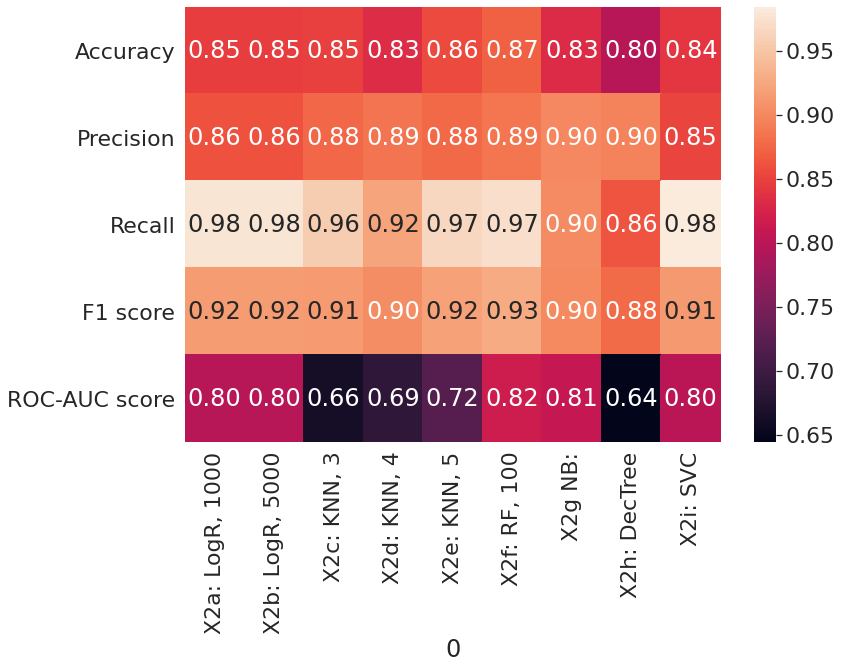

In [0]:
print('Fields in round 2:')
print(list(model12_fields))

featimp2 = pd.DataFrame(list(model12_fields))
featimp2 = featimp2.loc[0:16, :]

# Logistic regression, 0/1
X2a_score, X2a_precision, X2a_recall, X2a_f1, X2a_rocauc, X2a_confuse = run_logress(X2_train, X2_test, y2_train, y2_test, 1000)
X2a_results = pd.DataFrame(['X2a: LogR, 1000', X2a_score, X2a_precision, X2a_recall, X2a_f1, X2a_rocauc])
#print(X2a_results)

# Logistic regression, 0/1
X2b_score, X2b_precision, X2b_recall, X2b_f1, X2b_rocauc, X2b_confuse = run_logress(X2_train, X2_test, y2_train, y2_test, 5000)
X2b_results = pd.DataFrame(['X2b: LogR, 5000', X2b_score, X2b_precision, X2b_recall, X2b_f1, X2b_rocauc])
#print(X2b_results)


# K nearest neighbors
X2c_score, X2c_precision, X2c_recall, X2c_f1, X2c_rocauc, X2c_confuse = run_knear(X2_train, X2_test, y2_train, y2_test, 3)
X2c_results = pd.DataFrame(['X2c: KNN, 3', X2c_score, X2c_precision, X2c_recall, X2c_f1, X2c_rocauc])
#print(X2c_results)

# K nearest neighbors
X2d_score, X2d_precision, X2d_recall, X2d_f1, X2d_rocauc, X2d_confuse = run_knear(X2_train, X2_test, y2_train, y2_test, 4)
X2d_results = pd.DataFrame(['X2d: KNN, 4', X2d_score, X2d_precision, X2d_recall, X2d_f1, X2d_rocauc])
#print(X2d_results)

# K nearest neighbors
X2e_score, X2e_precision, X2e_recall, X2e_f1, X2e_rocauc, X2e_confuse = run_knear(X2_train, X2_test, y2_train, y2_test, 5)
X2e_results = pd.DataFrame(['X2e: KNN, 5', X2e_score, X2e_precision, X2e_recall, X2e_f1, X2e_rocauc])
#print(X2e_results)

# Random Forest
X2f_score, X2f_precision, X2f_recall, X2f_f1, X2f_rocauc, X2f_imp, X2f_confuse = run_forest(X2_train, X2_test, y2_train, y2_test, 100)
X2f_results = pd.DataFrame(['X2f: RF, 100', X2f_score, X2f_precision, X2f_recall, X2f_f1, X2f_rocauc])
#print(X2f_results)

# Naive Bayes
X2g_score, X2g_precision, X2g_recall, X2g_f1, X2g_rocauc, X2g_confuse = run_naive(X2_train, X2_test, y2_train, y2_test)
X2g_results = pd.DataFrame(['X2g NB:', X2g_score, X2g_precision, X2g_recall, X2g_f1, X2g_rocauc])
#print(X2g_results)

# Decision Trees
X2h_score, X2h_precision, X2h_recall, X2h_f1, X2h_rocauc, X2h_confuse = run_tree(X2_train, X2_test, y2_train, y2_test)
X2h_results = pd.DataFrame(['X2h: DecTree', X2h_score, X2h_precision, X2h_recall, X2h_f1, X2h_rocauc])
#print(X2h_results)

# Linear SVC
X2i_score, X2i_precision, X2i_recall, X2i_f1, X2i_rocauc, X2i_confuse = run_svc(X2_train, X2_test, y2_train, y2_test, 3000)
X2i_results = pd.DataFrame(['X2i: SVC', X2i_score, X2i_precision, X2i_recall, X2i_f1, X2i_rocauc])
#print(X2i_results)

# https://medium.com/swlh/recall-precision-f1-roc-auc-and-everything-542aedf322b9
x2frames = [X2a_results, X2b_results, X2c_results, X2d_results, X2e_results, X2f_results, X2g_results, X2h_results, X2i_results]
Results_forX2 = pd.concat(x2frames, axis=1)
Results_forX2.columns = Results_forX2.iloc[0]
Results_forX2 = Results_forX2.drop(index=0)
Results_forX2 = Results_forX2.rename(index={1:'Accuracy', 2:'Precision', 3:'Recall', 4:'F1 score', 5:'ROC-AUC score'})
Results_forX2 = Results_forX2.astype(float)
#print(Results_forX2)
print(sns.heatmap(Results_forX2, annot=True, fmt=".2f"))


# Feature importance from Random Forest
featimp2['Importance'] = X2f_imp
featimp2 = featimp2.sort_values('Importance', ascending=False)
print('X2 feature importance:')
featimp2

In [0]:
print('Field set 2 winners:\n')
print('Logistic regression')
print(X2a_confuse, '\n')
print('Naive Bayes')
print(X2g_confuse, '\n')
print('Random Forest')
print(X2f_confuse, '\n')
print('Linear SVC')
print(X2i_confuse)

Field set 2 winners:

Logistic regression
[[  26  239]
 [  34 1482]] 

Naive Bayes
[[ 113  152]
 [ 147 1369]] 

Random Forest
[[  77  188]
 [  41 1475]] 

Linear SVC
[[   6  259]
 [  24 1492]]


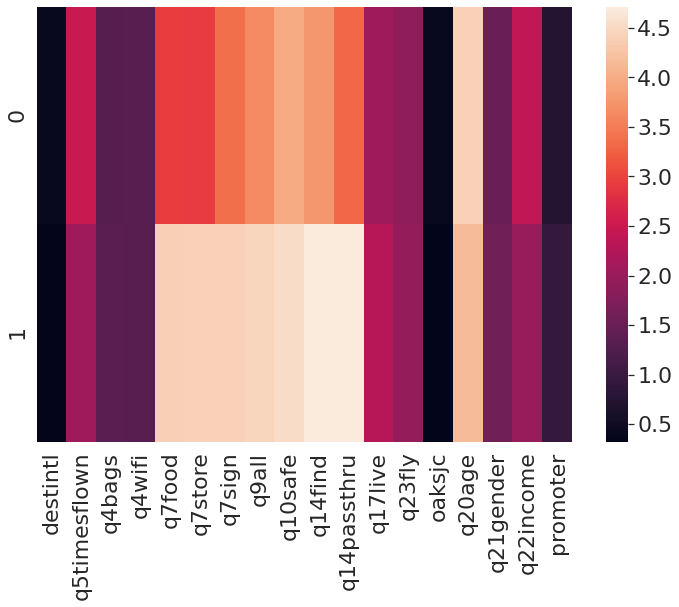

In [0]:
# reference: https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
names = model12_fields.columns
#sns.heatmap(flights_df, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

kmeans = KMeans(n_clusters=2)
kmeans.fit(model12_fields)
y_kmeans = kmeans.predict(model12_fields)
centers = kmeans.cluster_centers_
centers_df = pd.DataFrame(centers)
#centers_df = centers_df.transpose()
#print(centers)
sns.heatmap(centers_df, xticklabels=names)

## Model set 3

In [0]:
modelk_fields = model_fields[['q7food', 'q7sign', 'q9all', 'q10safe', 'q14find', 'q14passthru']]

In [0]:
featimp3 = pd.DataFrame(list(modelk_fields))
featimp3 = featimp3.loc[0:5, :]
featimp3

,0
0,q7food
1,q7sign
2,q9all
3,q10safe
4,q14find
5,q14passthru


In [0]:
# create training and test sets with 33/66 split

X3 = np.asarray(model_fields[['q7food', 'q7sign', 'q9all', 'q10safe', 'q14find', 'q14passthru']])
y = np.asarray(model_fields['promoter'])

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.33, random_state=42)

In [0]:
#check_distribution(X3_train, X3_test, y3_train, y3_test)

Fields in round 3:
['q7food', 'q7sign', 'q9all', 'q10safe', 'q14find', 'q14passthru']
AxesSubplot(0.125,0.125;0.62x0.755)
X3 feature importance:


,0,Importance
5,q14passthru,0.189250
0,q7food,0.177830
4,q14find,0.172219
1,q7sign,0.162223
2,q9all,0.151254
3,q10safe,0.147225


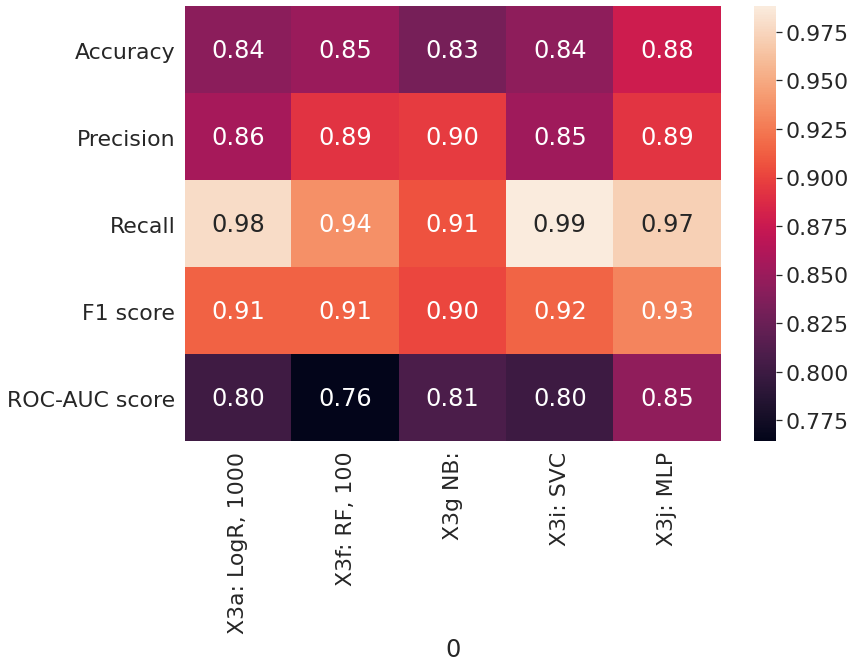

In [0]:
print('Fields in round 3:')
print(list(modelk_fields))

# Logistic regression, 0/1
X3a_score, X3a_precision, X3a_recall, X3a_f1, X3a_rocauc, X3a_confuse = run_logress(X3_train, X3_test, y3_train, y3_test, 1000)
X3a_results = pd.DataFrame(['X3a: LogR, 1000', X3a_score, X3a_precision, X3a_recall, X3a_f1, X3a_rocauc])
#print(X3a_results)

# Random Forest
X3f_score, X3f_precision, X3f_recall, X3f_f1, X3f_rocauc, X3f_imp, X3f_confuse = run_forest(X3_train, X3_test, y3_train, y3_test, 100)
X3f_results = pd.DataFrame(['X3f: RF, 100', X3f_score, X3f_precision, X3f_recall, X3f_f1, X3f_rocauc])
#print(X3f_results)

# Naive Bayes
X3g_score, X3g_precision, X3g_recall, X3g_f1, X3g_rocauc, X3g_confuse = run_naive(X3_train, X3_test, y3_train, y3_test)
X3g_results = pd.DataFrame(['X3g NB:', X3g_score, X3g_precision, X3g_recall, X3g_f1, X3g_rocauc])
#print(X3g_results)

# Linear SVC
X3i_score, X3i_precision, X3i_recall, X3i_f1, X3i_rocauc, X3i_confuse = run_svc(X3_train, X3_test, y3_train, y3_test, 3000)
X3i_results = pd.DataFrame(['X3i: SVC', X3i_score, X3i_precision, X3i_recall, X3i_f1, X3i_rocauc])
#print(X3i_results)

#MLP
X3j_score, X3j_precision, X3j_recall, X3j_f1, X3j_rocauc, X3j_confuse = run_mlp(X3_train, X3_test, y3_train, y3_test, 300)
X3j_results = pd.DataFrame(['X3j: MLP', X3j_score, X3j_precision, X3j_recall, X3j_f1, X3j_rocauc])

# https://medium.com/swlh/recall-precision-f1-roc-auc-and-everything-542aedf322b9
x3frames = [X3a_results, X3f_results, X3g_results,  X3i_results, X3j_results]
Results_forX3 = pd.concat(x3frames, axis=1)
Results_forX3.columns = Results_forX3.iloc[0]
Results_forX3 = Results_forX3.drop(index=0)
Results_forX3 = Results_forX3.rename(index={1:'Accuracy', 2:'Precision', 3:'Recall', 4:'F1 score', 5:'ROC-AUC score'})
Results_forX3 = Results_forX3.astype(float)
#print(Results_forX3)
print(sns.heatmap(Results_forX3, annot=True, fmt=".2f"))


# Feature importance from Random Forest
featimp3['Importance'] = X3f_imp
featimp3 = featimp3.sort_values('Importance', ascending=False)
print('X3 feature importance:')
featimp3

In [0]:
perfect = confusion_matrix(y3_test, y3_test)
perfect

array([[ 265,    0],
       [   0, 1516]])

In [0]:
print('Field set 3 winners:\n')
print('Logistic regression: ', X3a_rocauc)
print(X3a_confuse, '\n')
print('Naive Bayes: ', X3g_rocauc)
print(X3g_confuse, '\n')
print('Random Forest: ', X3f_rocauc)
print(X3f_confuse, '\n')
print('Linear SVC: ', X3i_rocauc)
print(X3i_confuse, '\n')
print('MLP: ', X3j_rocauc)
print(X3j_confuse, '\n')
print('Perfect')
print(perfect)

Field set 3 winners:

Logistic regression:  0.801701349131279
[[  17  248]
 [  32 1484]] 

Naive Bayes:  0.8079989545477173
[[ 106  159]
 [ 141 1375]] 

Random Forest:  0.7641895255637976
[[  93  172]
 [  95 1421]] 

Linear SVC:  0.80032981530343
[[   6  259]
 [  18 1498]] 

MLP:  0.8455232239757056
[[  88  177]
 [  42 1474]] 

Perfect
[[ 265    0]
 [   0 1516]]


## Tune Naive Bayes for model set 3

The most promising model (based on AUC ROC score) is the Naive Bayes model. There's only one parameter to tune for Naive Bayes: smoothing. I'm going to try several degrees of Laplacian smoothing to see which works best. 

In [0]:
# Loop for tuning the Gaussian Naive Bayes model we used above
# reference: https://stackoverflow.com/questions/51194627/python-naive-bayes-with-cross-validation-using-gaussiannb-classifier

steps = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

results = []
for step in steps:
  smooth_x, f1_x, rocauc_x, conf_matx = tune_naive (X3_train, X3_test, y3_train, y3_test, step)
  evaluators = [smooth_x, f1_x, rocauc_x, conf_matx]
  results.append(evaluators)

results_gnb = pd.DataFrame(results)
results_gnb = results_gnb.rename(columns= {0: 'Smoothing', 1: 'F1 score', 2: 'Roc Auc score', 3: 'Confusion Matrix'})
results_gnb

,Smoothing,F1 score,Roc Auc score,Confusion Matrix
0,1.000000e-09,0.901639,0.807999,"[[106, 159], [141, 1375]]"
1,1.000000e-08,0.901639,0.807999,"[[106, 159], [141, 1375]]"
2,1.000000e-07,0.901639,0.807999,"[[106, 159], [141, 1375]]"
3,1.000000e-06,0.901639,0.807999,"[[106, 159], [141, 1375]]"
4,1.000000e-05,0.901639,0.807999,"[[106, 159], [141, 1375]]"
5,1.000000e-04,0.901639,0.808004,"[[106, 159], [141, 1375]]"
6,1.000000e-03,0.901344,0.808019,"[[105, 160], [141, 1375]]"
7,1.000000e-02,0.901704,0.807982,"[[105, 160], [140, 1376]]"
8,1.000000e-01,0.906744,0.807718,"[[87, 178], [111, 1405]]"


In [0]:
# Just in case, try the bernouilli version of Naive Bayes
# it works much worse than Gaussian

f1_x, rocauc_x, conf_matx = tune_bern (X3_train, X3_test, y3_train, y3_test)
evaluators = [f1_x, rocauc_x, conf_matx]

results_bnb = pd.DataFrame(evaluators)
results_bnb = results_bnb.rename(index= {0: 'F1 score', 1: 'Roc Auc score', 2: 'Confusion Matrix'})
results_bnb

,0
F1 score,0.916337
Roc Auc score,0.512218
Confusion Matrix,"[[0, 265], [10, 1506]]"


In [0]:
# 40% correct on the negative cases in Model 3 (Gaussian) is not superfab, but it's the best we saw

correct_neg = 106/265
print("Negative correct:", correct_neg)
correct_pos = 1375/1516
print("Positive correct:", correct_pos)

Negative correct: 0.4
Positive correct: 0.9069920844327177


## EDA on the winning fields

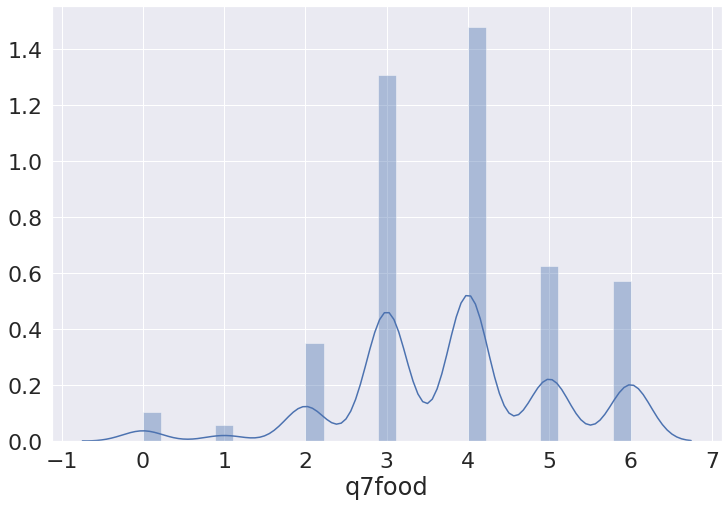

In [0]:
# 'q7food', 'q7sign', 'q9all', 'q10safe', 'q14find', 'q14passthru'

sns.distplot(model_fields['q7food'])

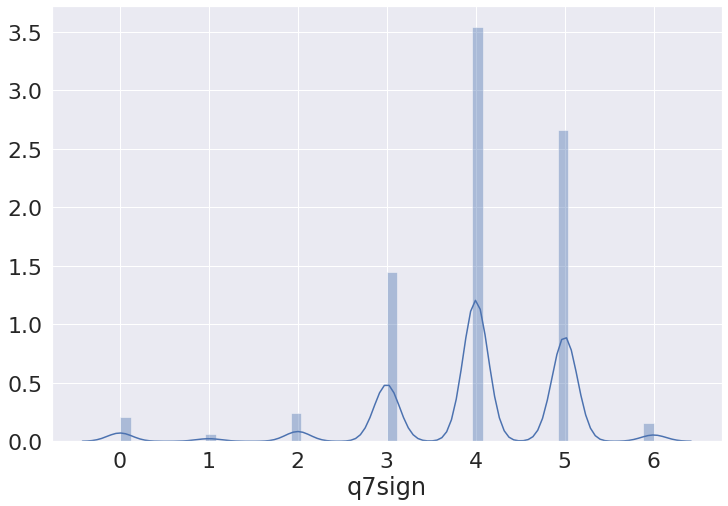

In [0]:
sns.distplot(model_fields['q7sign'])

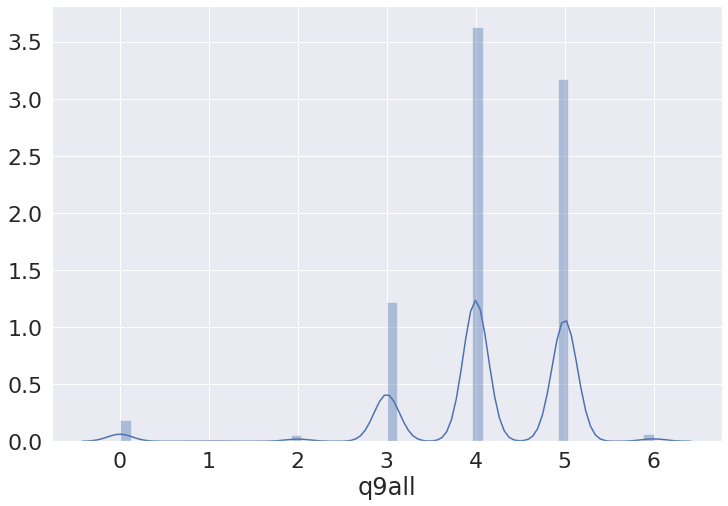

In [0]:
sns.distplot(model_fields['q9all'])

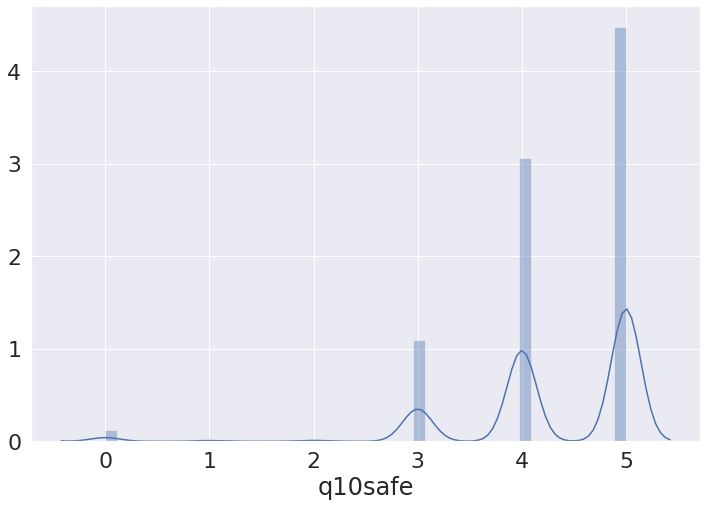

In [0]:
sns.distplot(model_fields['q10safe'])

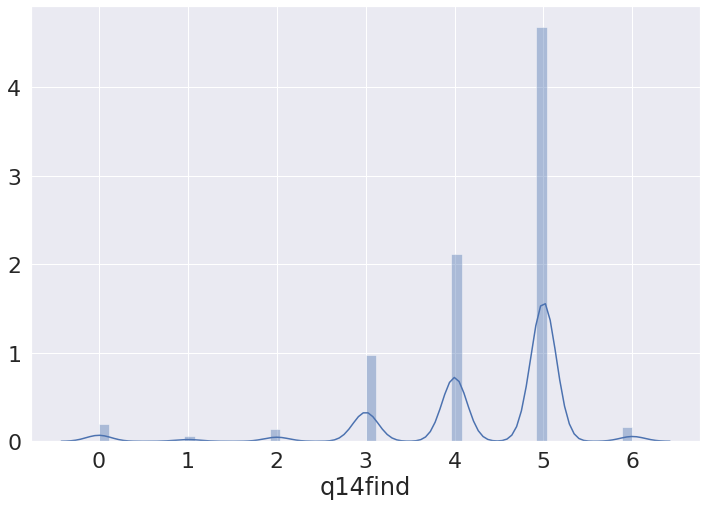

In [0]:
sns.distplot(model_fields['q14find'])

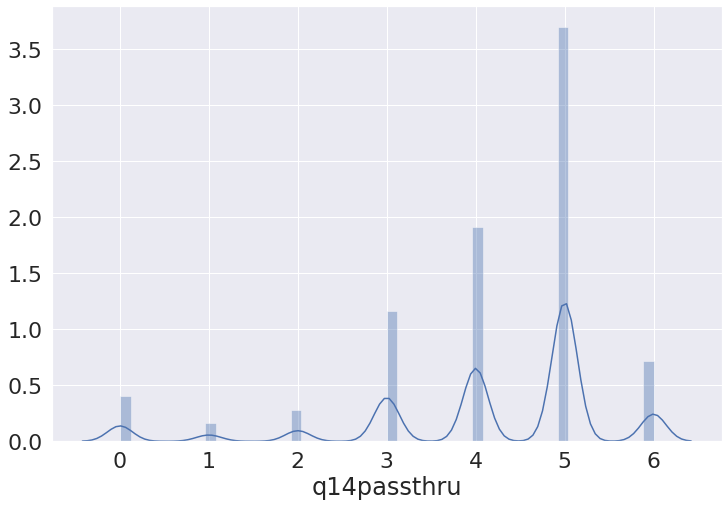

In [0]:
sns.distplot(model_fields['q14passthru'])

# Prepare data for export to dashboard

The dashboard will let people use sliders to alter the input to the "prediction", but rather than actually run the prediction live I will predict all possible values in advance. This is practical only because the model has six fields instead of the original 95. 

In [0]:
winners = model_fields[['q7food', 'q7sign', 'q9all', 'q10safe', 'q14find', 'q14passthru']]


In [0]:
print('q7food:', winners['q7food'].unique())
print('q7sign:', winners['q7sign'].unique())
print('q9all:', winners['q9all'].unique())
print('q10safe:', winners['q10safe'].unique())
print('q14find:', winners['q14find'].unique())
print('q14passthru:', winners['q14passthru'].unique())

#reference: https://chrisalbon.com/python/data_wrangling/pandas_list_unique_values_in_column/

q7food: [6 3 5 4 2 1 0]
q7sign: [3 4 5 1 2 6 0]
q9all: [4 3 5 0 2 6 1]
q10safe: [4 3 5 2 1 0]
q14find: [4 5 3 6 2 0 1]
q14passthru: [4 5 6 3 0 1 2]


In [0]:
# reference: https://stackoverflow.com/questions/48285893/python-combination-of-two-columns

# this crashed colab for using all available RAM
food = winners['q7food'].unique()
sign = winners['q7sign'].unique()
clean = winners['q9all'].unique()
safe = winners['q10safe'].unique()
find = winners['q14find'].unique()
security = winners['q14passthru'].unique()
outlist = [ (i, j, k, l, m, n)
    for i in food
    for j in sign
    for k in clean
    for l in safe
    for m in find
    for n in security]


In [0]:
outlist[1]

(6, 3, 4, 4, 4, 5)

In [0]:
winners_pred = pd.DataFrame(data=outlist, columns=['q7food','q7sign', 'q9all', 'q10safe', 'q14find', 'q14passthru'])
winners_pred.head(8)

,q7food,q7sign,q9all,q10safe,q14find,q14passthru
0,6,3,4,4,4,4
1,6,3,4,4,4,5
2,6,3,4,4,4,6
3,6,3,4,4,4,3
4,6,3,4,4,4,0
5,6,3,4,4,4,1
6,6,3,4,4,4,2
7,6,3,4,4,5,4


In [0]:
winners_pred.to_csv('/content/drive/My Drive/WesternSkiesRepo/ist718group/dash_combinations.csv')

In [0]:
# to run this you also need to have run the train/test creation for X3
  
def predict_dash(list_combo):
  listx = list(list_combo)
  win_bay = sklearn.naive_bayes.GaussianNB()
  win_bay.fit(X3_train, y3_train)
  #  y_proba = win_bay.predict_proba(X3_test)[:,1]
  y_proba = win_bay.predict_proba(listx)
  y_pred = win_bay.predict(listx)

  # giving the average of the probability array, and then turning the prediction from an array to a number
  return y_proba[0][0],y_proba[0][1], y_pred[0]

In [0]:
# testing with one row
predict_dash([[6, 3, 4, 4, 4, 5]])

(0.06597740505639017, 0.9340225949436105, 1)

In [0]:
try1 = list(winners_pred.iloc[0, 0:6])
try1
predict_dash([try1])

(0.08401956894529422, 0.915980431054706, 1)

In [0]:
test = predict_dash([list(winners_pred.iloc[0, 0:6])])
print(test[0])
print(test[1])
test

(array([[0.08401957, 0.91598043]]), 1)

In [0]:
test = predict_dash([winners_pred.iloc[0, 0:6]])
print(test[0])
print(test[1])

0.08401956894529422
0.915980431054706


In [0]:
test2 = predict_dash([winners_pred.iloc[0, 0:6]])
print(test2[0])
print(test2[1])

0.08401956894529422
0.915980431054706


In [0]:
temp = winners_pred.head(8)
temp

,q7food,q7sign,q9all,q10safe,q14find,q14passthru
0,6,3,4,4,4,4
1,6,3,4,4,4,5
2,6,3,4,4,4,6
3,6,3,4,4,4,3
4,6,3,4,4,4,0
5,6,3,4,4,4,1
6,6,3,4,4,4,2
7,6,3,4,4,5,4


In [0]:
temp.apply( lambda row: print(row), axis=1)

q7food         6
q7sign         3
q9all          4
q10safe        4
q14find        4
q14passthru    4
Name: 0, dtype: int64
q7food         6
q7sign         3
q9all          4
q10safe        4
q14find        4
q14passthru    5
Name: 1, dtype: int64
q7food         6
q7sign         3
q9all          4
q10safe        4
q14find        4
q14passthru    6
Name: 2, dtype: int64
q7food         6
q7sign         3
q9all          4
q10safe        4
q14find        4
q14passthru    3
Name: 3, dtype: int64
q7food         6
q7sign         3
q9all          4
q10safe        4
q14find        4
q14passthru    0
Name: 4, dtype: int64
q7food         6
q7sign         3
q9all          4
q10safe        4
q14find        4
q14passthru    1
Name: 5, dtype: int64
q7food         6
q7sign         3
q9all          4
q10safe        4
q14find        4
q14passthru    2
Name: 6, dtype: int64
q7food         6
q7sign         3
q9all          4
q10safe        4
q14find        5
q14passthru    4
Name: 7, dtype: int64


0    None
1    None
2    None
3    None
4    None
5    None
6    None
7    None
dtype: object

In [0]:
temp.apply( lambda row: predict_dash([row]), axis=1)

0    (0.08401956894529422, 0.915980431054706, 1) 
1    (0.06597740505639017, 0.9340225949436105, 1)
2    (0.05925722939310874, 0.9407427706068917, 1)
3    (0.12120664579297742, 0.8787933542070222, 1)
4    (0.530591864663315, 0.4694081353366845, 0)  
5    (0.32622256181325027, 0.6737774381867492, 1)
6    (0.19364287505479455, 0.8063571249452051, 1)
7    (0.053864470856687274, 0.946135529143313, 1)
dtype: object

In [0]:
#temp_pred = temp
#temp_pred['prediction'] = temp_pred.apply( lambda row: predict_dash([row]), axis=1)
#temp_pred

In [0]:
temp_pred = temp
temp_pred['probability0'], temp_pred['probability1'], temp_pred['prediction'] = zip(*temp_pred.apply( lambda row: predict_dash([row]), axis=1))
temp_pred

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,q7food,q7sign,q9all,q10safe,q14find,q14passthru,probability0,probability1,prediction
0,6,3,4,4,4,4,0.084020,0.915980,1
1,6,3,4,4,4,5,0.065977,0.934023,1
2,6,3,4,4,4,6,0.059257,0.940743,1
3,6,3,4,4,4,3,0.121207,0.878793,1
4,6,3,4,4,4,0,0.530592,0.469408,0
5,6,3,4,4,4,1,0.326223,0.673777,1
6,6,3,4,4,4,2,0.193643,0.806357,1
7,6,3,4,4,5,4,0.053864,0.946136,1


In [0]:
#temp_pred['probability'], temp_pred['prediction'] = zip(*temp_pred.apply( lambda row: predict_dash([row]), axis=1))
winners_pred['probability0'], winners_pred['probability1'], winners_pred['prediction'] = zip(*winners_pred.apply( lambda row: predict_dash([row]), axis=1))
winners_pred.head(15)

,q7food,q7sign,q9all,q10safe,q14find,q14passthru,probability0,probability1,prediction
0,6,3,4,4,4,4,0.084020,0.915980,1
1,6,3,4,4,4,5,0.065977,0.934023,1
2,6,3,4,4,4,6,0.059257,0.940743,1
3,6,3,4,4,4,3,0.121207,0.878793,1
4,6,3,4,4,4,0,0.530592,0.469408,0
5,6,3,4,4,4,1,0.326223,0.673777,1
6,6,3,4,4,4,2,0.193643,0.806357,1
7,6,3,4,4,5,4,0.053864,0.946136,1
8,6,3,4,4,5,5,0.042001,0.957999,1
9,6,3,4,4,5,6,0.037624,0.962376,1


In [0]:
# save results to a file for Joe
winners_pred.to_csv('/content/drive/My Drive/WesternSkiesRepo/ist718group/dash_predictions.csv')

### EDA on results
What does the model identify? 

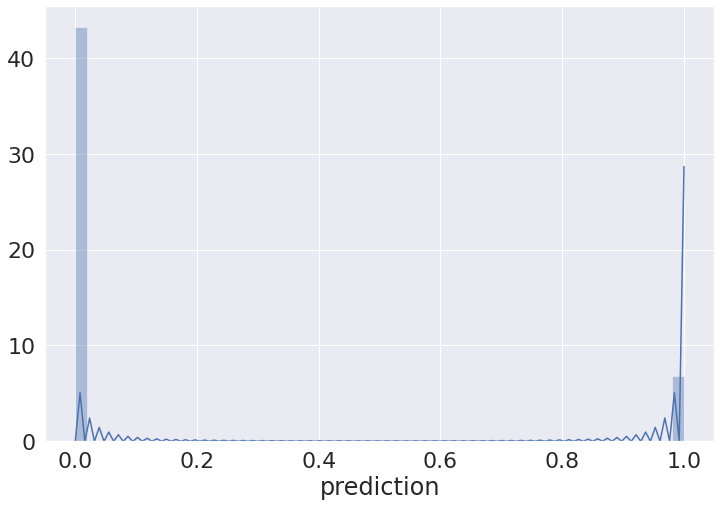

In [0]:
sns.distplot(winners_pred['prediction'])

In [0]:
all_detractors = winners_pred[winners_pred['prediction'] == 0]
all_detractors.head(10)

,q7food,q7sign,q9all,q10safe,q14find,q14passthru,probability,prediction
4,6,3,4,4,4,0,0.5,0
18,6,3,4,4,3,0,0.5,0
19,6,3,4,4,3,1,0.5,0
31,6,3,4,4,2,3,0.5,0
32,6,3,4,4,2,0,0.5,0
33,6,3,4,4,2,1,0.5,0
34,6,3,4,4,2,2,0.5,0
35,6,3,4,4,0,4,0.5,0
36,6,3,4,4,0,5,0.5,0
37,6,3,4,4,0,6,0.5,0


In [0]:
# https://towardsdatascience.com/getting-more-value-from-the-pandas-value-counts-aa17230907a6#:~:text=The%20value_counts()%20method%20returns,unique%20entries%20in%20that%20column.

detractors_food = all_detractors['q7food'].value_counts(normalize=True)
detractors_sign = all_detractors['q7sign'].value_counts(normalize=True)
detractors_clean = all_detractors['q9all'].value_counts(normalize=True)
detractors_safe = all_detractors['q10safe'].value_counts(normalize=True)
detractors_find = all_detractors['q14find'].value_counts(normalize=True)
detractors_security = all_detractors['q14passthru'].value_counts(normalize=True)

In [0]:
worst_ratings = [detractors_food, detractors_sign, detractors_clean, detractors_safe, detractors_find, detractors_security]
worst = pd.DataFrame(worst_ratings)

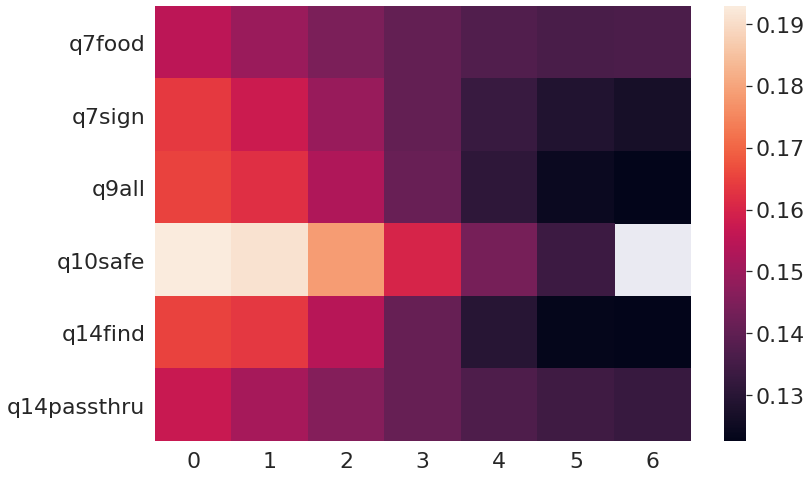

In [0]:
sns.heatmap(worst)